<h2><center>Case Study: Applying the scRNAseq Pipeline to Mice Brain Cells<h2><center>![0_7sB0C827S4SRvMf9.webp](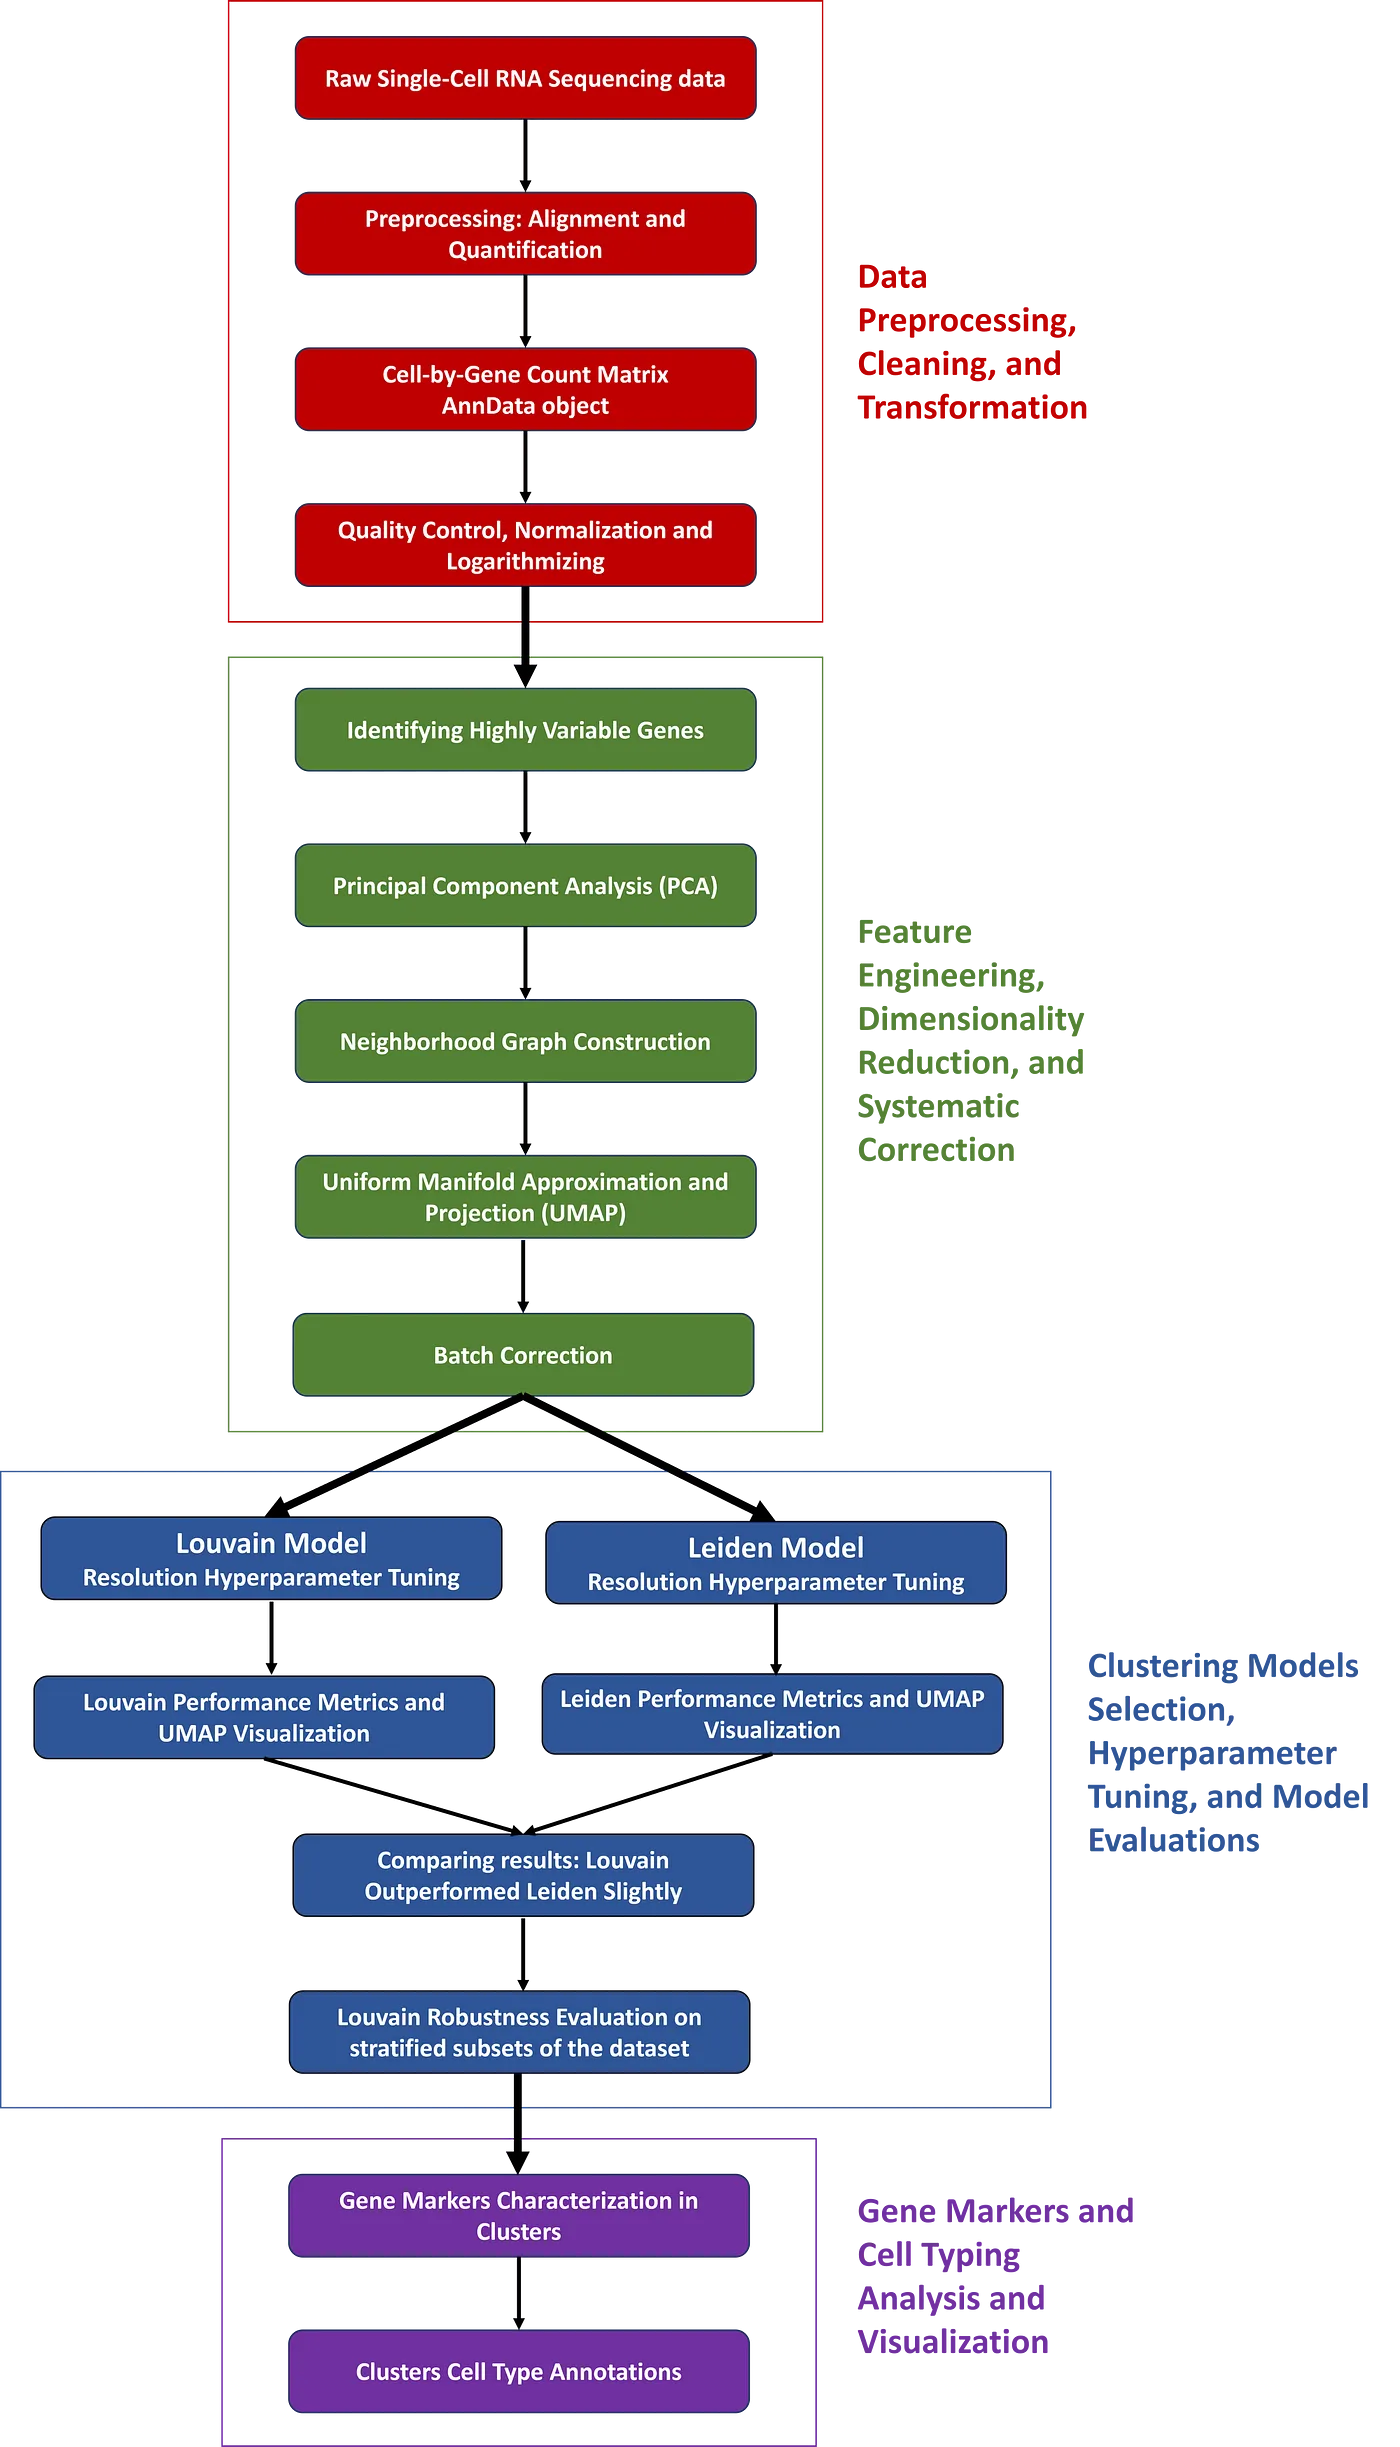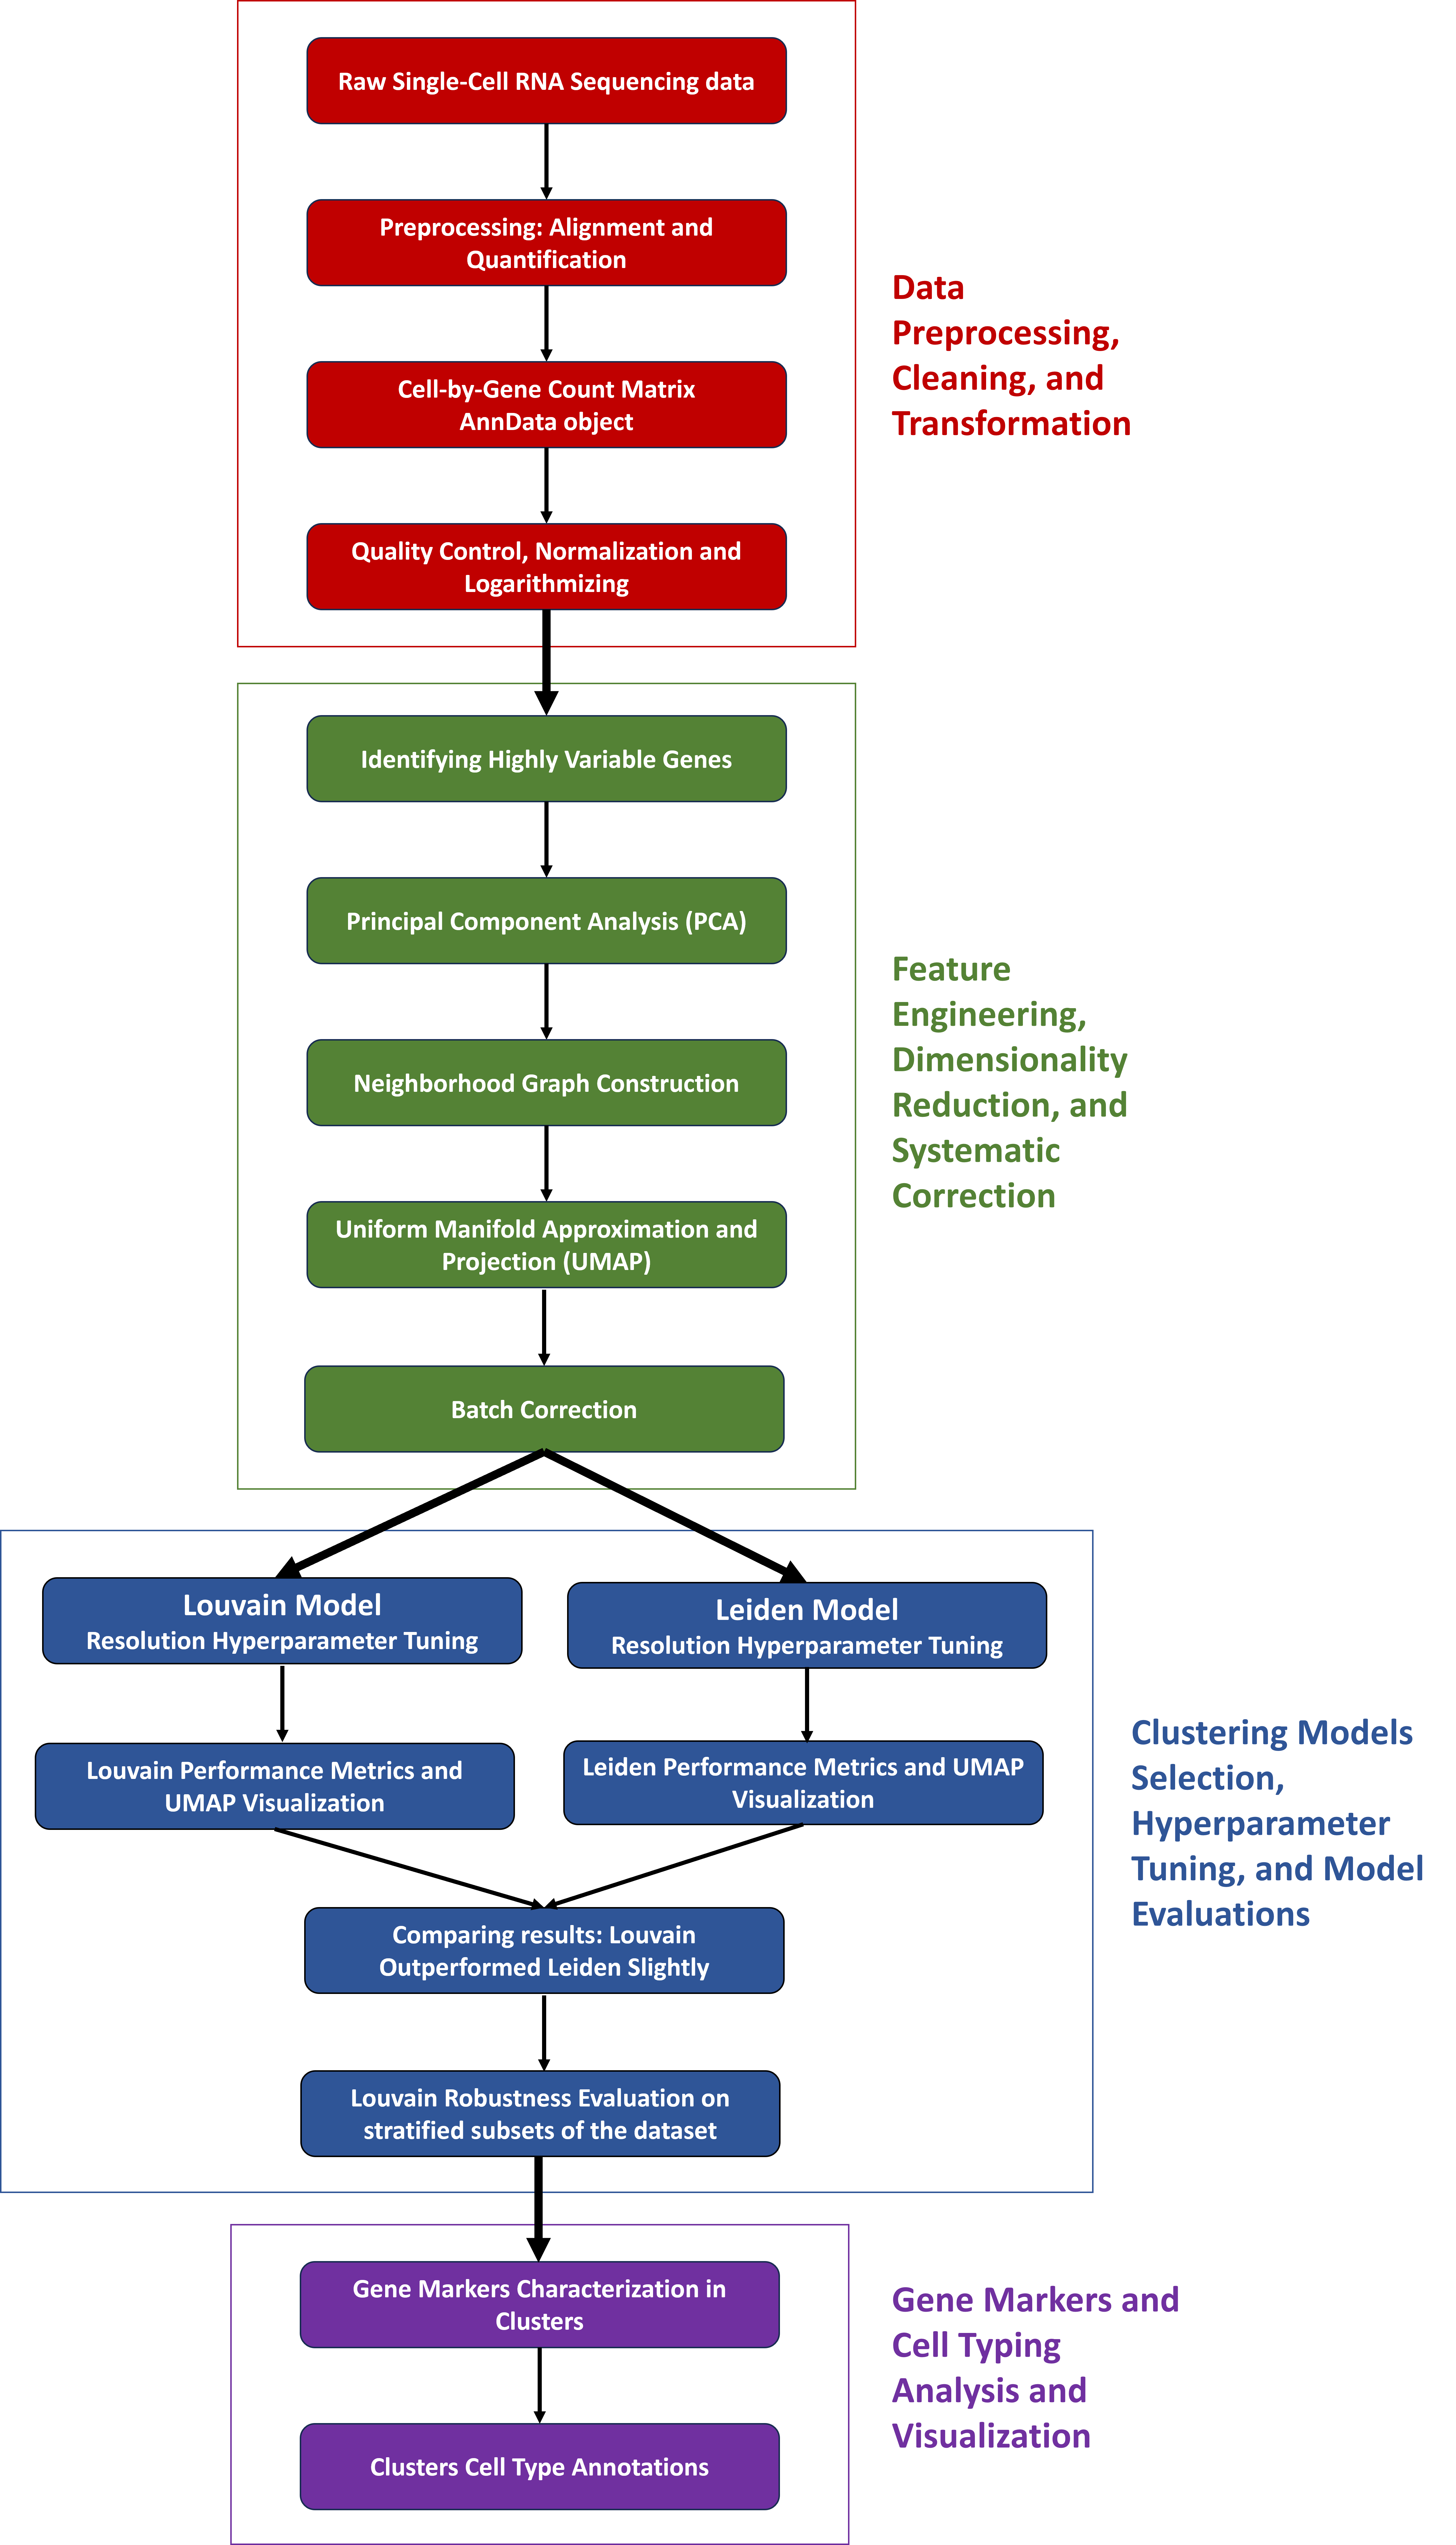)

In [55]:
# Importing Libraries
!pip install scanpy
!pip install igraph
!pip3 install louvain
!pip install leidenalg
import igraph
import louvain
import leidenalg
import scanpy as sc
import anndata
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.sparse import csr_matrix
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

np.random.seed(223)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.8 MB/s eta 0:00:00


In [2]:
#Mounting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id='1'></a>
# 1. Introduction

<a id='11'></a>
## 1.1. Project Motivation

My last course at Minerva was a student-led course on practical applications of data science. In this course, we had a chance to learn thee basics of data science from each other and explore different topics that interested us.

Yousry, one of my classmates, developed a single-cell RNA-sequencing (sc-RNA-seq) pipeline for his portfolio project. I found this topic deeply fascinating, so this project is my extension of Yoursry's project for brain cells (Elsadec, 2024).

sc-RNA-seq has many promising applications for brain cells. Through this methodology, we might be able to form a more sophisticated understanding of genetic expressions in brain cells. Such an understanding can advance the studies of neurological and neudegenerative disease by revealing pathogenic and/or regenerative cells and pathways for drug discovery (Ofengeim et al., 2017).

<a id='12'></a>
## 1.2. Dataset


In this exploration of single-cell RNA-sequencing models, I will use Tabula Muris as an example. The Tabula Muris is a collaborative effort to profile every mouse tissue at a single-cell level. The full dataset includes both high throughput but low-coverage 10X data and lower throughput but high-coverage Smartseq2 data.

This notebook used Smartseq2 data from the mouse brain. This data consists of:

1. An expression matrix where each column corresponds to a gene and each row corresponds to a single cell.
2. A metadata table describing each cell.

<a id='12'></a>
## 1.3. State of Current research


sc-RNA-seq is a particularly challenging but promising avenue of research in neuroscience. Neurons are known to be particularly challenging to work with, since there is more complexity associated with these cells and the taxonomy of neurons is still largely in development (Zeng, 2017). However, recent models have been successful at decoding some of the neuronal complexity, revealing insight into key areas of research such as composition of visual pathways (Hrvatin et al., 2018) and Alzheimer's pathology (Mathys et al., 2019).

<a id='2'></a>
# 2. Data Processing

<a id='21'></a>
## 2.1. Exploring and preparing data

First, uploading the gene expression matrix.

In [135]:
#Importing the counts of genes for single cells
count_dataframe = pd.read_csv('/content/drive/MyDrive/brain/brain_counts.csv',index_col=0)
count_dataframe.head()

0610005C13Rik  0610007C21Rik  0610007L01Rik  \
A1.B003290.3_38_F.1.1                0            125             16   
A1.B003728.3_56_F.1.1                0              0              0   
A1.MAA000560.3_10_M.1.1              0            348              0   
A1.MAA000564.3_10_M.1.1              0             41             36   
A1.MAA000923.3_9_M.1.1               0             53              0   

                         0610007N19Rik  0610007P08Rik  0610007P14Rik  \
A1.B003290.3_38_F.1.1                0              0              0   
A1.B003728.3_56_F.1.1                0              0            324   
A1.MAA000560.3_10_M.1.1              0              0              5   
A1.MAA000564.3_10_M.1.1              0              0             24   
A1.MAA000923.3_9_M.1.1               0              0              0   

                         0610007P22Rik  0610008F07Rik  0610009B14Rik  \
A1.B003290.3_38_F.1.1                0              0              0   
A1.B003728.3_56_F.1.1                0              0              0   
A1.MAA000560.3_10_M.1.1              0              0              0   
A1.MAA000564.3_10_M.1.1              0              0              0   
A1.MAA000923.3_9_M.1.1               0              0              0   

                         0610009B22Rik  ...  Zxdb  Zxdc  Zyg11a  Zyg11b  Zyx  \
A1.B003290.3_38_F.1.1                0  ...     0     0       0       0    0   
A1.B003728.3_56_F.1.1                0  ...     0     0       0       0    0   
A1.MAA000560.3_10_M.1.1              0  ...     0     0       0       0    0   
A1.MAA000564.3_10_M.1.1             14  ...     0     0       0       0  125   
A1.MAA000923.3_9_M.1.1               0  ...     0     0       0      81    0   

                         Zzef1  Zzz3  a  l7Rn6  zsGreen_transgene  
A1.B003290.3_38_F.1.1        0     0  0     54                  0  
A1.B003728.3_56_F.1.1        0     0  0      0                  0  
A1.MAA000560.3_10_M.1.1    195     0  0    113                  0  
A1.MAA000564.3_10_M.1.1      0     1  0      0                  0  
A1.MAA000923.3_9_M.1.1       0     0  0      0                  0  

[5 rows x 23433 columns]

Now the metadata, which contains the key information about samples, ontology, and subtissues.

In [136]:
#Importing the metadata with information about cell types and tissues
meta_dataframe = pd.read_csv('/content/drive/MyDrive/brain/brain_metadata.csv',index_col=0)
meta_dataframe.head()

cell_ontology_class    subtissue mouse.sex mouse.id  \
cell                                                                          
A1.B003290.3_38_F.1.1             astrocyte     Striatum         F   3_38_F   
A1.B003728.3_56_F.1.1             astrocyte     Striatum         F   3_56_F   
A1.MAA000560.3_10_M.1.1     oligodendrocyte       Cortex         M   3_10_M   
A1.MAA000564.3_10_M.1.1    endothelial cell     Striatum         M   3_10_M   
A1.MAA000923.3_9_M.1.1            astrocyte  Hippocampus         M    3_9_M   

                        plate.barcode  
cell                                   
A1.B003290.3_38_F.1.1         B003290  
A1.B003728.3_56_F.1.1         B003728  
A1.MAA000560.3_10_M.1.1     MAA000560  
A1.MAA000564.3_10_M.1.1     MAA000564  
A1.MAA000923.3_9_M.1.1      MAA000923

In [137]:
#Showing counts for cells by subtissue type
print(pd.value_counts(meta_dataframe['subtissue']))

subtissue
Cortex         1149
Hippocampus     976
Striatum        723
Cerebellum      553
Name: count, dtype: int64


It will be a crucial step to combine these data into an Anndata object. Such an object allows us to see store both metadata and matrices in an accessible way for analyses.

In [138]:
#Combining the metadata with gene x cell matrix into an Anndata object
adata = sc.AnnData(X = count_dataframe, obs = meta_dataframe)
print(adata.shape)

(3401, 23433)


<a id='22'></a>
## 2.2. Spikes (Specific to Neurons)

Some Smartseq2 data have spike-ins, which are RNA transcripts of known and sequence that are used to calibrate data as a control probe. These are artefacts of the measuring process and do not actually represent the collect data. These gene names contain ERCC and can be filtered out. Below, I will make a column where we either label a gene as True or False based on ERCC presence.

In [139]:
is_spike_in = {}
number_of_spike_ins = 0

for gene_name in adata.var_names:
    if 'ERCC' in gene_name:
        is_spike_in[gene_name] = True # record that we found a spike-in
        number_of_spike_ins += 1 # bump up the counter
    else:
        is_spike_in[gene_name] = False # record that this was not a spike-in

adata.var['ERCC'] = pd.Series(is_spike_in) # because the index of adata.var and the keys of is_spike_in match, anndata will take care of matching them up
print('Number of spike ins: ', number_of_spike_ins)

Number of spike ins:  92


We have a total number of 92 spike-ins and will need to filter these based on known thresholds later.

In [140]:
adata.var.head()

ERCC
0610005C13Rik  False
0610007C21Rik  False
0610007L01Rik  False
0610007N19Rik  False
0610007P08Rik  False

In [141]:
adata.obs.head()

cell_ontology_class    subtissue mouse.sex mouse.id  \
cell                                                                          
A1.B003290.3_38_F.1.1             astrocyte     Striatum         F   3_38_F   
A1.B003728.3_56_F.1.1             astrocyte     Striatum         F   3_56_F   
A1.MAA000560.3_10_M.1.1     oligodendrocyte       Cortex         M   3_10_M   
A1.MAA000564.3_10_M.1.1    endothelial cell     Striatum         M   3_10_M   
A1.MAA000923.3_9_M.1.1            astrocyte  Hippocampus         M    3_9_M   

                        plate.barcode  
cell                                   
A1.B003290.3_38_F.1.1         B003290  
A1.B003728.3_56_F.1.1         B003728  
A1.MAA000560.3_10_M.1.1     MAA000560  
A1.MAA000564.3_10_M.1.1     MAA000564  
A1.MAA000923.3_9_M.1.1      MAA000923

<a id='3'></a>
# 3. Cleaning data


<a id='31'></a>
## 3.1. Quality control

For quality control, we want to try balancing out the sample size with the level of information we get from each gene. In most cases, the problem in sc-rna-seq lies in the fact that there are too many genes and only a few types of cells. Most gene expression matrices are quite sparse due to this, so we would ideally shave off data on genes that are not crucial for classifying cell types without sacrificing the bulk of the data that could be useful for clustering.

In [142]:
#Dividing the dataset into samples to perform quality control on each sample
unique_samples = adata.obs['mouse.id'].unique()
sample_data = {}
for sample in unique_samples:
    sample_data[sample] = adata[adata.obs['mouse.id'] == sample].copy()

adata38 = sample_data['3_38_F']
adata56 = sample_data['3_56_F']
adata10 = sample_data['3_10_M']
adata9 = sample_data['3_9_M']

We will take a look at each sample to understand what we are working with. The samples are quite unbalanced, as is often the case with such data.

In [143]:
adata38

AnnData object with n_obs × n_vars = 355 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC'

In [144]:
adata56

AnnData object with n_obs × n_vars = 111 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC'

In [145]:
adata10

AnnData object with n_obs × n_vars = 980 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC'

In [146]:
adata9

AnnData object with n_obs × n_vars = 871 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC'

To perform quality control, two functions were used - one for visualizing the counts of total cells, genes, and spike-ins and another for removing data based on manually set thresholds.

In [147]:
def data_quality_control_check(adata):
    """
    Perform quality control (QC) analysis on an AnnData object used in scRNA-seq data analysis.

    This function calculates and adds QC metrics to the AnnData object for each cell. These metrics include
    the total counts of RNA molecules per cell, the number of detected genes, and the fraction of
    spike-ins. It also generates violin plots and scatter plots for these metrics to assist
    in determining appropriate threshold values for further quality control filtering.

    Parameters:
    -----------
    adata : AnnData
        An AnnData object containing scRNA-seq data. This object should have cells as rows and genes as columns.

    Returns:
    --------
    adata : AnnData
        The modified AnnData object with added QC metrics. The metrics added are 'n_genes_by_counts' (number of
        genes detected in each cell), 'total_counts' (total number of RNA molecules detected per cell), and
        'pct_counts_ercc' (percentage of counts belonging to spike-ins).

    Description:
    ------------
    The function identifies ERCC cells based on the labeling done above.

    The function uses Scanpy's `calculate_qc_metrics` to compute these metrics and adds them to the AnnData
    object. It also generates violin plots for the number of genes, total counts, and percentage of spike-ins,
    as well as scatter plots to visualize the relationship between total counts and the number
    of genes, and total counts versus spike-in gene percentage. These plots are essential for assessing
    the quality of the data and deciding on thresholds for filtering out low-quality cells.
    """

    # Calculate quality check metrics, particularly: total counts, no. of genes, and MT genes fraction
    sc.pp.calculate_qc_metrics(adata, qc_vars = ['ERCC'],percent_top=None, log1p=True, inplace=True)


    # Produce a violin plot for the quality check metrics
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts','pct_counts_ERCC'],
             jitter=0.4, multi_panel=True)

    # Produce scatter plots for total count vs mitochondrial genes and gene count
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_ERCC')

    return adata

In [80]:
def data_quality_control_apply(adata, min_counts, min_genes, max_genes, max_ercc):

    """
    Apply a series of quality control filters to an AnnData object from scRNA-seq data.

    This function performs several filtering steps to remove low-quality cells based on specified
    criteria: the maximum total counts, the minimum and maximum number of genes expressed, and the
    maximum percentage of spike0in gene counts. The function prints the number of cells in the
    dataset after each filtering step for tracking the impact of each criterion.

    Parameters:
    -----------
    adata : AnnData
        An AnnData object containing single-cell RNA sequencing data, with cells as rows and genes as columns.
    min_genes : int
        Minimum number of genes that must be expressed in a cell. Cells with fewer expressed genes will
        be filtered out.
    max_genes : int
        Maximum number of genes that must be expressed in a cell. Cells with more expressed genes will
        be filtered out.
    max_pct_ercc : float
        Maximum allowed percentage of spike-in gene counts. Cells with a higher percentage will be
        filtered out.

    Returns:
    --------
    AnnData
        The filtered AnnData object.

    Description:
    ------------
    The function begins by filtering genes that are detected in at least a minimum number of cells.
    It then applies a series of cell-level filters based on total counts, number of genes expressed,
    and spike-in gene expression. These filters help in identifying and removing potential outliers
    or cells with poor-quality data, such as controls for measurements.

    """

    # Number of cells before any filtering
    print('Total number of cells before filtering: {:d}'.format(adata.n_obs))

    # Filter out counts over min_counts
    sc.pp.filter_cells(adata, min_counts = min_counts)
    print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

    # Filter out cells with under min_genes genes
    sc.pp.filter_cells(adata, min_genes = min_genes)
    print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

    #Filter out cells with over max_genes genes
    sc.pp.filter_cells(adata, max_genes = max_genes)
    print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

    adata = adata[adata.obs['pct_counts_ERCC'] < max_ercc].copy()

    print('Number of cells after ERCC pct filter: {:d}'.format(adata.n_obs))

    return adata

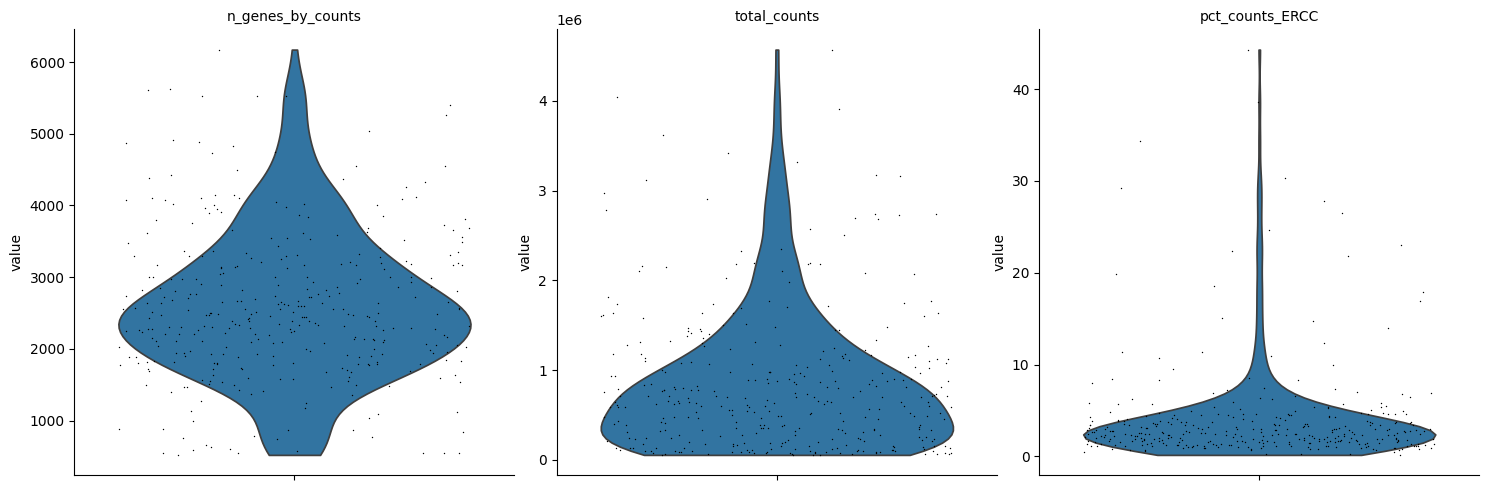

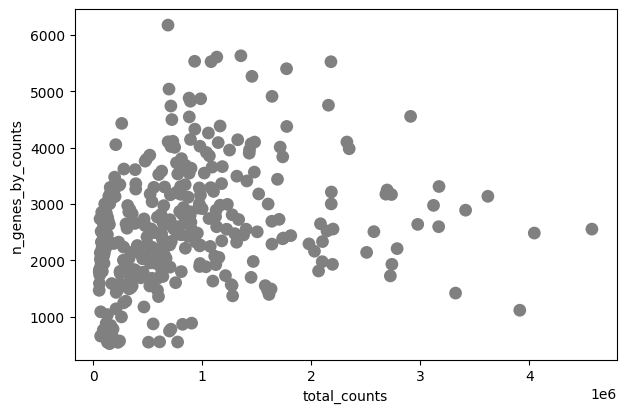

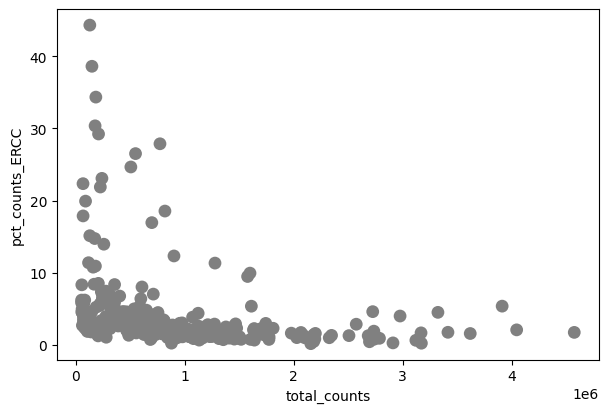

AnnData object with n_obs × n_vars = 355 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [148]:
data_quality_control_check(adata38)

In [149]:
adata38 = data_quality_control_apply(adata38, min_counts=0, min_genes=0, max_genes=6500, max_ercc=10)
adata38

Total number of cells before filtering: 355
Number of cells after min count filter: 355
Number of cells after gene filter: 355
Number of cells after gene filter: 355
Number of cells after ERCC pct filter: 332


AnnData object with n_obs × n_vars = 332 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_counts', 'n_genes'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

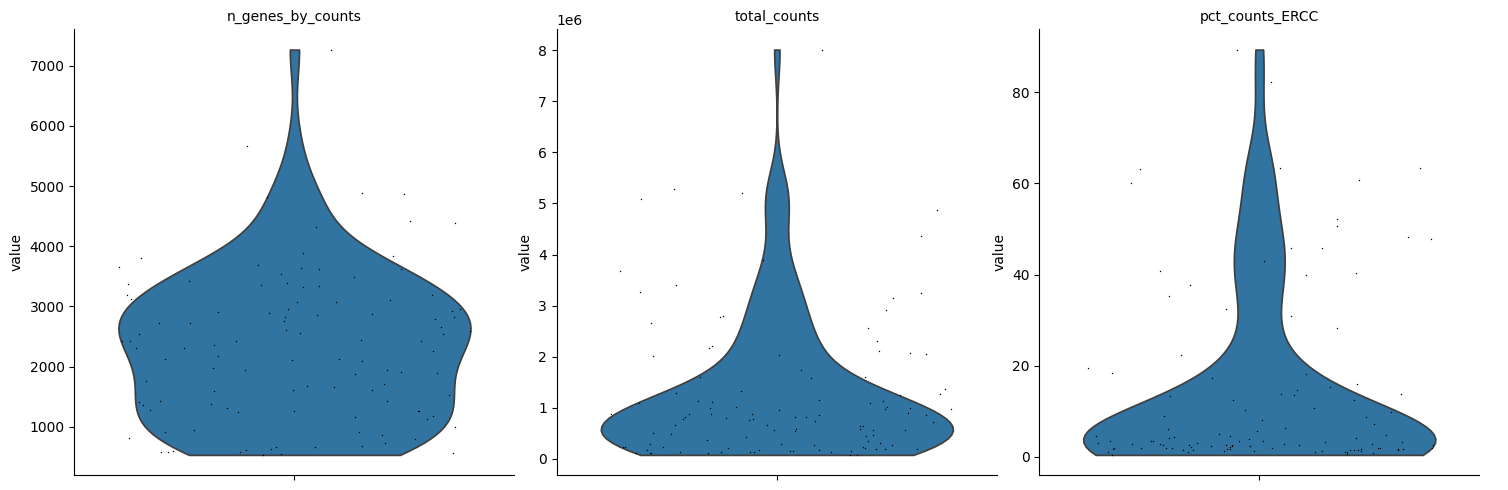

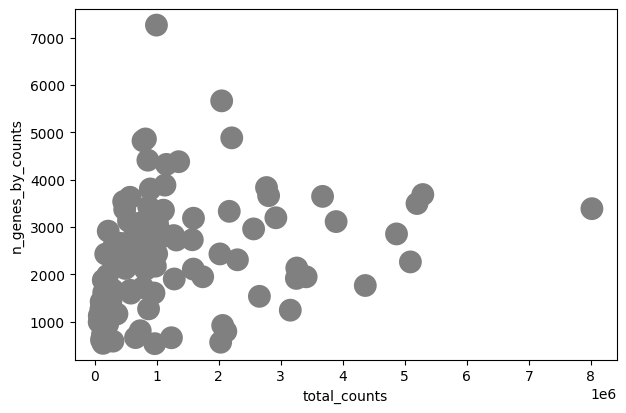

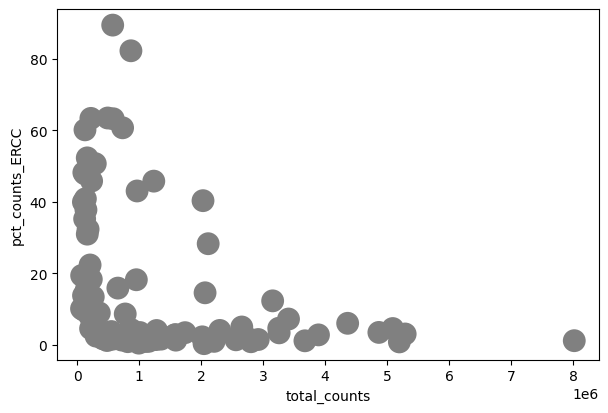

AnnData object with n_obs × n_vars = 111 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [150]:
data_quality_control_check(adata56)

In [151]:
adata56 = data_quality_control_apply(adata56, min_counts=0, min_genes=400, max_genes=7000, max_ercc=10)
adata56

Total number of cells before filtering: 111
Number of cells after min count filter: 111
Number of cells after gene filter: 111
Number of cells after gene filter: 110
Number of cells after ERCC pct filter: 72


AnnData object with n_obs × n_vars = 72 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_counts', 'n_genes'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

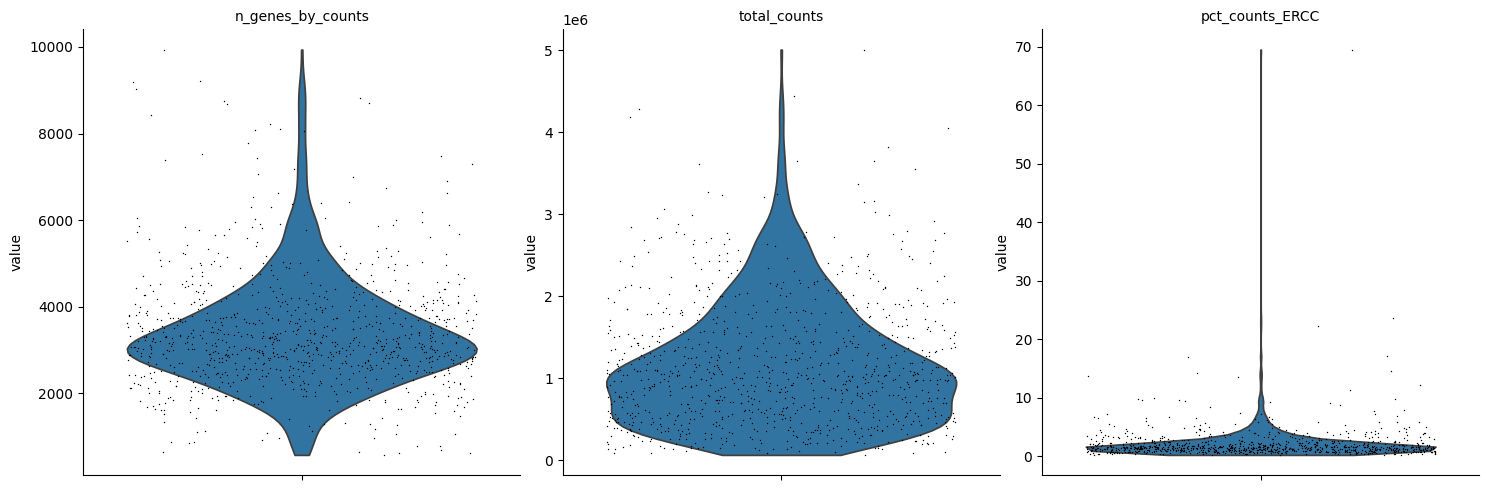

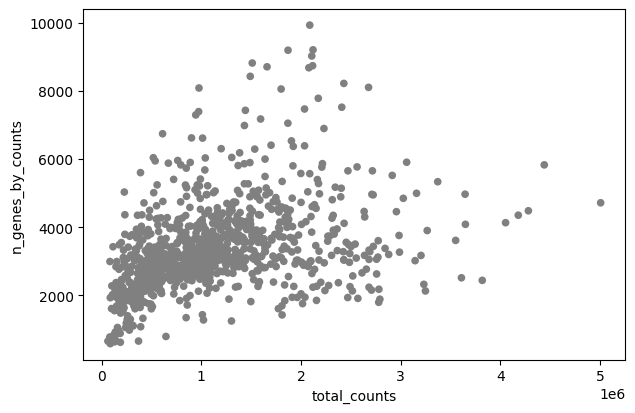

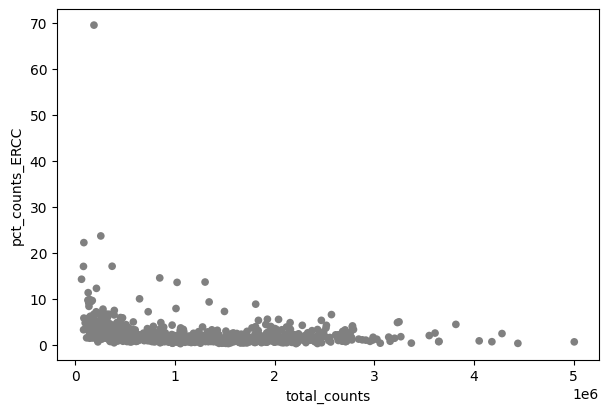

AnnData object with n_obs × n_vars = 980 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [152]:
data_quality_control_check(adata10)

In [153]:
adata10 = data_quality_control_apply(adata10, min_counts=0, min_genes=750, max_genes=10000, max_ercc=10)
adata10

Total number of cells before filtering: 980
Number of cells after min count filter: 980
Number of cells after gene filter: 974
Number of cells after gene filter: 974
Number of cells after ERCC pct filter: 967


AnnData object with n_obs × n_vars = 967 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_counts', 'n_genes'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

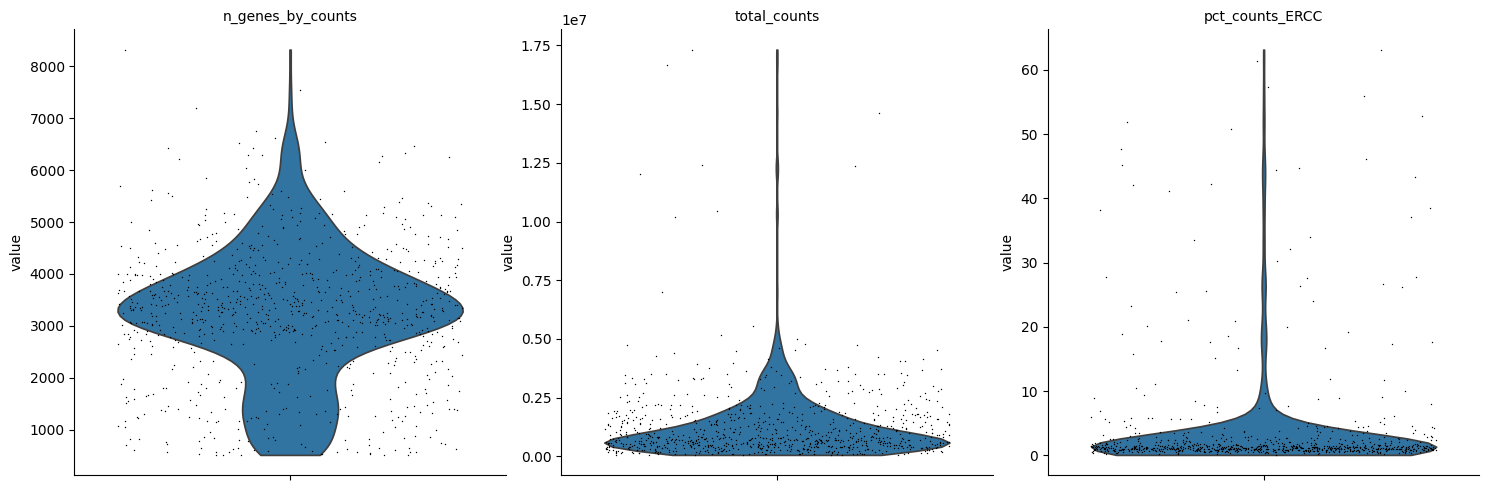

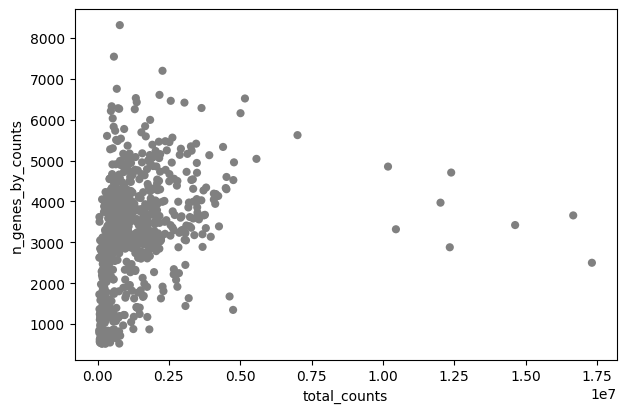

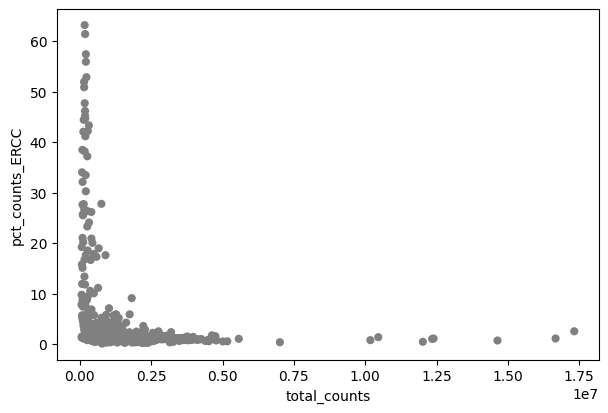

AnnData object with n_obs × n_vars = 871 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [154]:
data_quality_control_check(adata9)

In [155]:
adata9 = data_quality_control_apply(adata9, min_counts=0, min_genes=750, max_genes=8500, max_ercc=10)
adata9

Total number of cells before filtering: 871
Number of cells after min count filter: 871
Number of cells after gene filter: 836
Number of cells after gene filter: 836
Number of cells after ERCC pct filter: 814


AnnData object with n_obs × n_vars = 814 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_counts', 'n_genes'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

<a id='32'></a>
## 3.2. Combining sample data into a single object and filtering genes with low cell counts

In [156]:
# Concatenate all the samples from donors we have (38, 56, 10, 9) in adata_all
adata = anndata.concat(
    {bc: ad for bc, ad in zip(['38', '56', '10', '9'], [adata38, adata56, adata10, adata9])},
    label='sample',
    merge="same"
)
adata

AnnData object with n_obs × n_vars = 2185 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_counts', 'n_genes', 'sample'
    var: 'ERCC'

In [157]:
# Filter genes

print('Total number of genes: {:d}'.format(adata.n_vars))

# Basic filtering - a Gene must be at least detected in 30 cells
sc.pp.filter_genes(adata, min_cells=30)

print('Number of genes after filtering: {:d}'.format(adata.n_vars))

Total number of genes: 23433
Number of genes after filtering: 14352


<a id='32'></a>
## 3.2. Normalizing data

In [158]:
# Keep the count data in a counts layer.
adata.layers["counts"] = adata.X.copy()

In [159]:
# Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell.
sc.pp.normalize_total(adata, target_sum=1e4)

In [160]:
# Logarithmize the data
sc.pp.log1p(adata)

In [162]:
# Save the normalized and logarithmized raw data in the .raw attribute of the anndata.
adata.raw = adata

<a id='4'></a>
# 4. Feature Engineering, Dimensionality Reduction, and Systematic Correction

<a id='41'></a>
# 4.1. Identifying highly variable genes

The next step is to look at which genes are the most highly variable and dispersed. This is a key step of the analysis, since it enables us to focus on the key genes for better cliustering results. The scanpy module for finding highly variable genes focuses on showing genes that are likely highly variable naturally, not just due to chance.

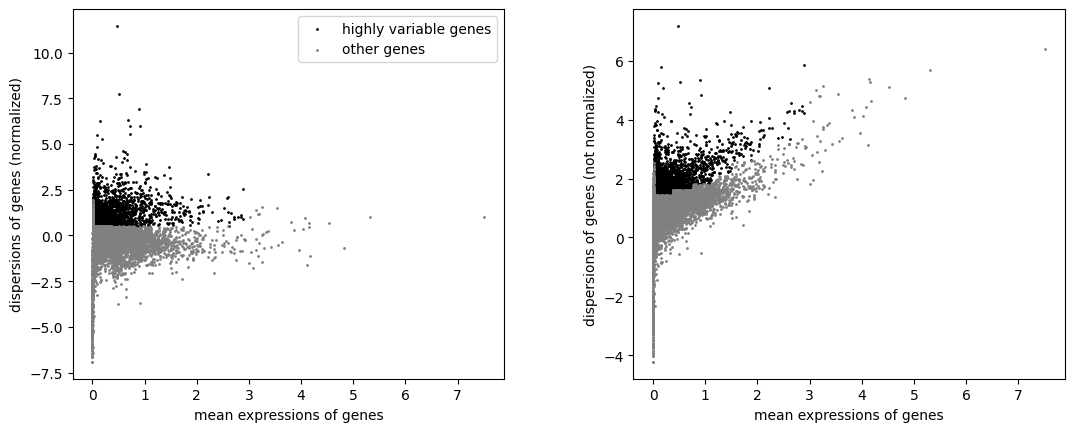

In [163]:
# Extracting highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Visualization of highly variable genes
sc.pl.highly_variable_genes(adata)

# Get only highly variable genes
adata = adata[:, adata.var.highly_variable]

We can see here that anything above a 6.5 is unlikely to result in any meaningful clustering, so we will set that as a threshold. After trying many variations of analysis in this project, I believe going below this threshold with the smaller brain dataset would shave off too much data.

<a id='42'></a>
# 4.2. Principal component analysis (PCA)

PCA reduces gene data dimension to focus on the most significant variance within genes.

In [164]:
#Scaling the data to unit variance and clip values above standard deviation of 7.5.
sc.pp.scale(adata, max_value=6.5)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [165]:
adata_explore = adata.copy()

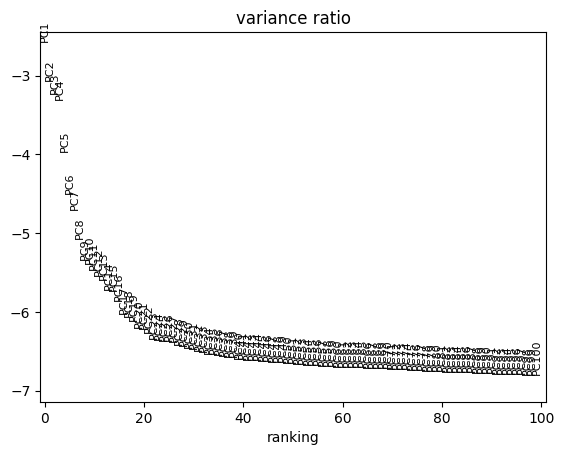

In [166]:
# Performing Principal Component Analysis (PCA)
sc.tl.pca(adata_explore, n_comps=100, svd_solver='arpack')

# Visualize elbow plot for the variance ratio across principal components
sc.pl.pca_variance_ratio(adata_explore,n_pcs=100, log=True)

<a id='43'></a>
# 4.3. Neighborhood graphs

We can see according to the PCA graph that after 80 components, the variance among genes significantly flattens. We can now use this information and focus on the most important variance to construct a neighborhood graph. The scanpy neighborhood graph constructor uses Euclidian distances between cells and shows how cells are connected based on their gene expressions.

The number of neighbors is a parameter that can help us either focus more or less on local cell structures. I used the default number of 15 neighbors.

In [167]:
# Calculate the neighborhood graph with 80 PCs.
sc.pp.neighbors(adata_explore, n_pcs=80) # n_neighbors = 15 by default.

<a id='44'></a>
# 4.4. Uniform Manifold Approximation and Projection (UMAP)

UMAP is a technique used to embed neighborhood structures into 2 dimensions. UMAP is known for preserving global structures and being efficient to run on larger datasets.

In [168]:
# UMAP calculation
sc.tl.umap(adata_explore) # min_dist = 0.5 by default

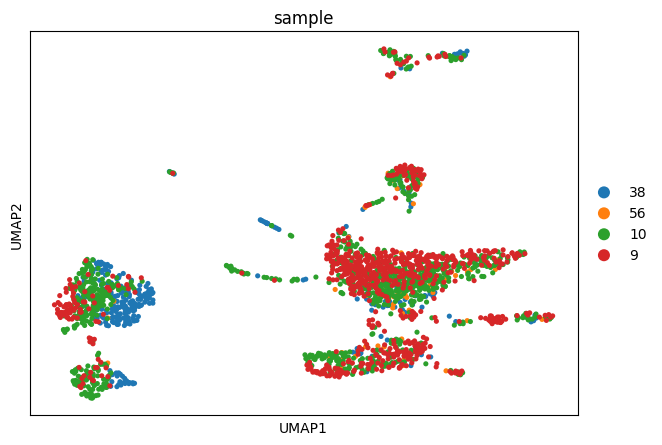

In [169]:
# Visualize the UMAP with highlighting the different five samples in the dataset
sc.pl.scatter(adata_explore, basis='umap', color='sample')

In [170]:
# Performing Principal Component Analysis (PCA)
sc.pp.pca(adata, n_comps=80, use_highly_variable=True, svd_solver='arpack')

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [171]:
# Calculate the neighborhood graph with 70 PCs.
sc.pp.neighbors(adata, n_pcs=70) # n_neighbors = 15 by default.

In [172]:
# UMAP calculation
sc.tl.umap(adata, min_dist = 0.5)  # min_dist = 0.5 by default

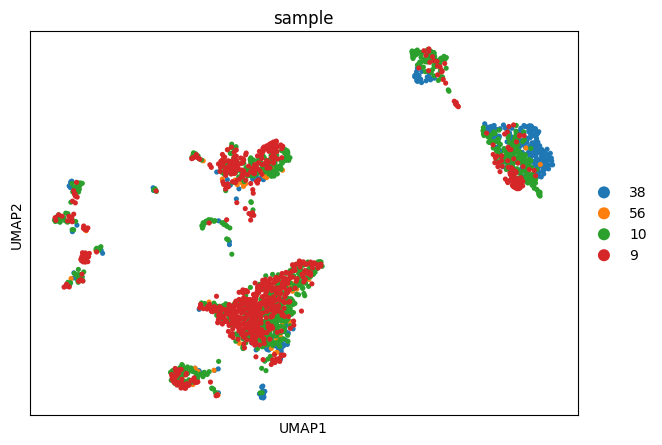

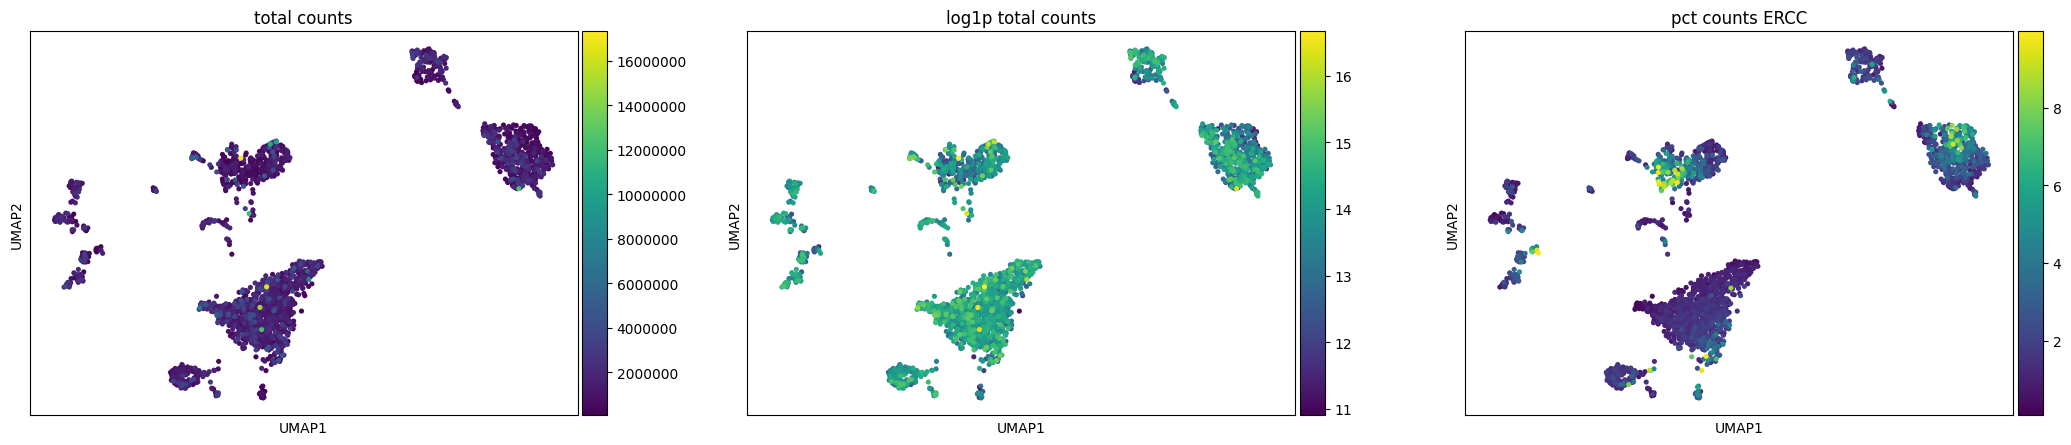

In [173]:
# Visualize the UMAP with highlighting the different five samples in the dataset
sc.pl.scatter(adata, basis='umap', color='sample')
# Visualizing the distribution of data quality metrics in the UMAP
sc.pl.scatter(adata, basis='umap', color=[ 'total_counts', 'log1p_total_counts', 'pct_counts_ERCC'])

In [175]:
adata

AnnData object with n_obs × n_vars = 2185 × 3382
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_counts', 'n_genes', 'sample'
    var: 'ERCC', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

<a id='5'></a>
# 5. Preparing to Cluster

Now, we will actually try to cluster the gene expressions into cells types. To ensure we can assess the performance of an unsupervised clustering algorithm, the data can be split into two samples, so that the performance on two separate clusters can be compared to the performance on the entire dataset. If the algorithm is pretty consistent across these comparisons, it performs well.

The stratified sampling strategy first divides the UMAP space into a grid of 100 bins along each axis, assigning cells accordingly. Then, the cells are distributed across two subsets, maintaining bin representation, and then split into two comprehensive subsets.


In [176]:
# Define bins or regions for splitting

# Get UMAP coordinates
umap_coords = adata.obsm['X_umap']

# Define grid boundaries (these could be based on quantiles or other criteria)
x_bins = np.linspace(min(umap_coords[:,0]), max(umap_coords[:,0]), 100)
y_bins = np.linspace(min(umap_coords[:,1]), max(umap_coords[:,1]), 100)

# Digitize the UMAP coordinates to bin indices
x_bin_indices = np.digitize(umap_coords[:,0], x_bins)
y_bin_indices = np.digitize(umap_coords[:,1], y_bins)

# Combine the bin indices to form a stratification key
stratification_key = x_bin_indices * (1000) + y_bin_indices

In [47]:
# Splitting the data into two subsets. Here, we perform stratified splitting.
# However, if a bin has only one sample, we randomly assign the sample to a subset.

# Check if any bin has fewer than 2 samples
unique, counts = np.unique(stratification_key, return_counts=True)
# Find bins with fewer than 2 samples
bins_with_fewer_than_two = unique[counts == 1]

# Create masks for cells in bins with at least two samples and with only one sample
mask_fewer_than_two = np.isin(stratification_key, bins_with_fewer_than_two)
mask_at_least_two = ~mask_fewer_than_two

# Split indices into two groups
indices_fewer_than_two = np.where(mask_fewer_than_two)[0]
indices_at_least_two = np.where(mask_at_least_two)[0]

# Perform stratified split on cells in bins with at least two samples
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for first_subset_idx_stratified, second_subset_idx_stratified in sss.split(X=np.zeros(
    len(indices_at_least_two)), y=stratification_key[mask_at_least_two]):
    pass

# Adjust indices to original data
first_subset_idx_stratified = indices_at_least_two[first_subset_idx_stratified]
second_subset_idx_stratified = indices_at_least_two[second_subset_idx_stratified]

# Randomly assign cells from bins with fewer than two samples
first_subset_idx_random, second_subset_idx_random = train_test_split(indices_fewer_than_two, test_size=0.5, random_state=42)

# Combine indices from both stratified and random splits
first_idx = np.concatenate((first_subset_idx_stratified, first_subset_idx_random))
second_idx = np.concatenate((second_subset_idx_stratified, second_subset_idx_random))

# Create First and Second subsets
first_subset_adata = adata[first_idx].copy()
second_subset_adata = adata[second_idx].copy()

In [48]:
print(first_subset_adata,'\n \n', second_subset_adata)

AnnData object with n_obs × n_vars = 1092 × 3382
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_counts', 'n_genes', 'sample'
    var: 'ERCC', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities' 
 
 AnnData object with n_obs × n_vars = 1093 × 3382
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'n_counts', 'n_genes', 'sample'
    var: 'ERCC', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dis

# 6. Clustering models

## 6.1 Louvian model

The first model is a Louvian model, which uses modularity as its optimization functin. It makes sure the density of links within a group is higher than the density between different groups

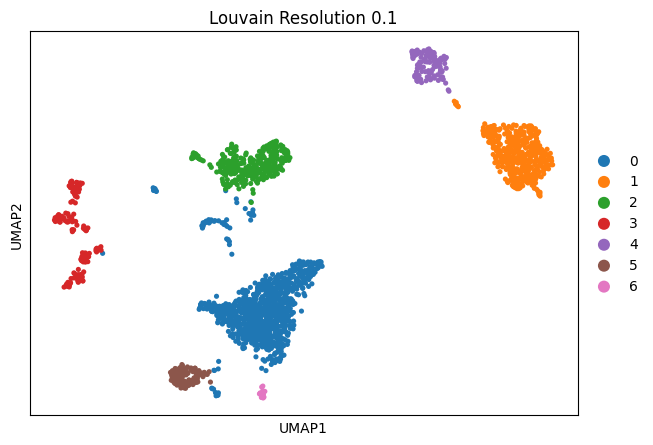

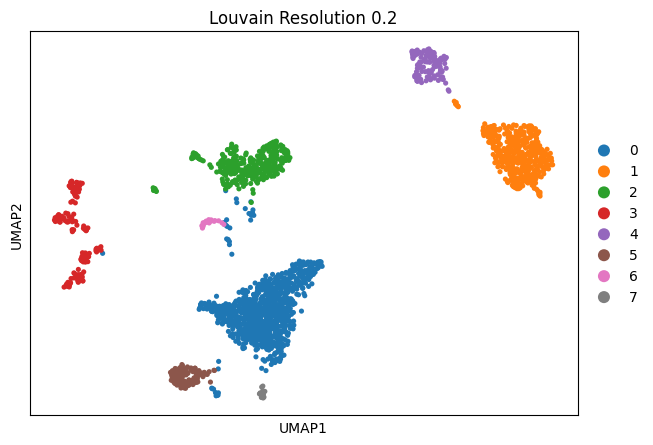

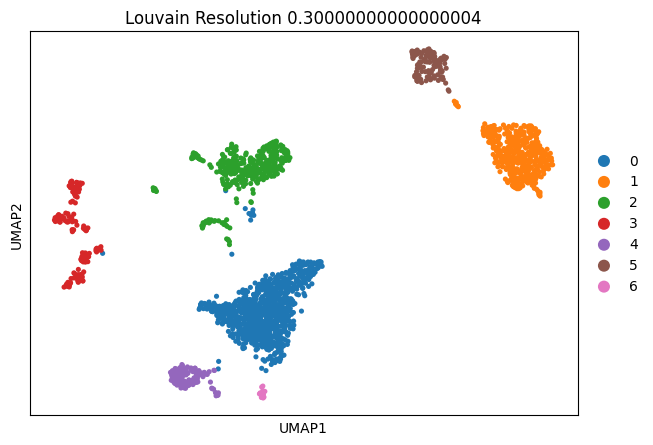

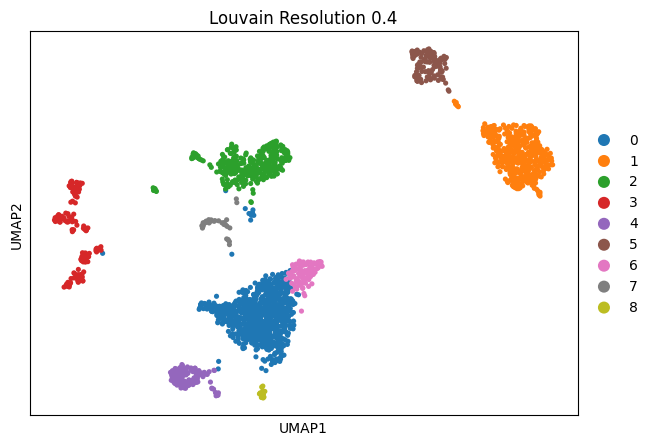

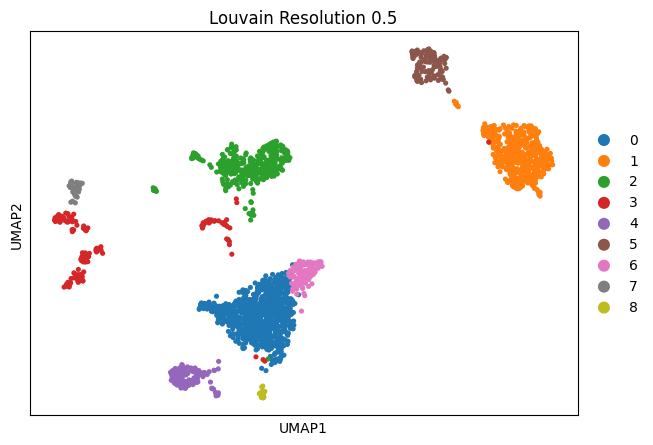

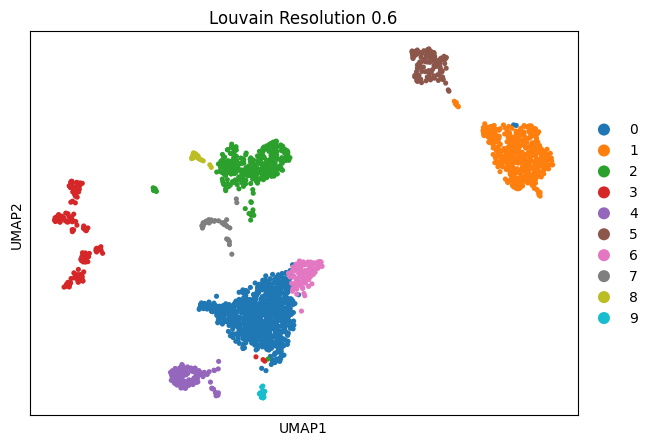

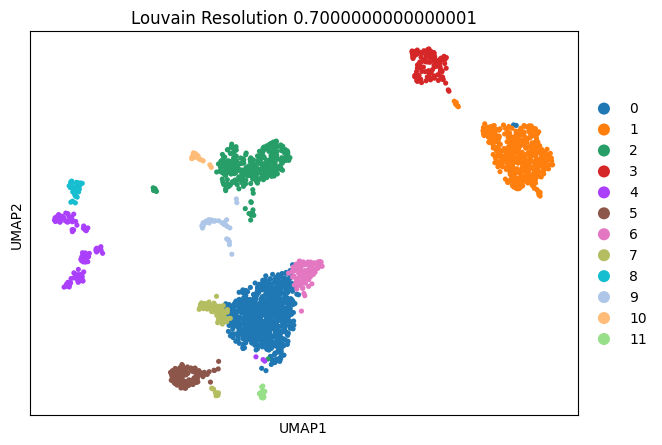

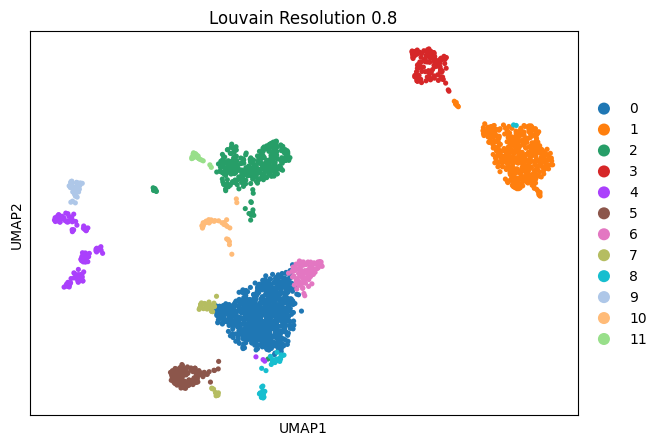

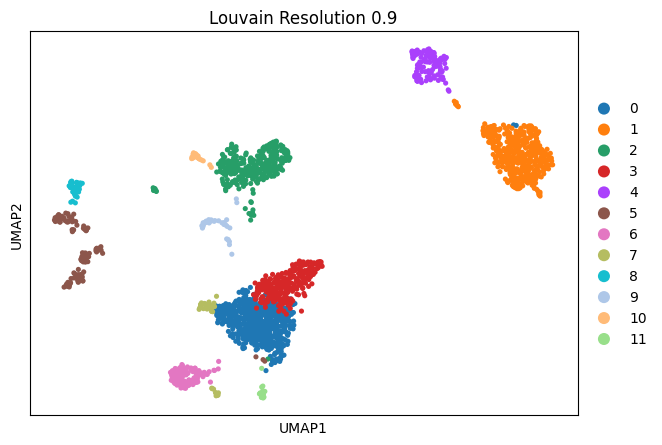

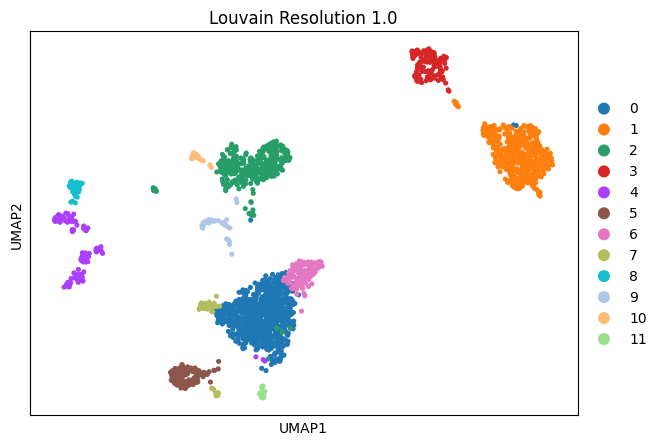

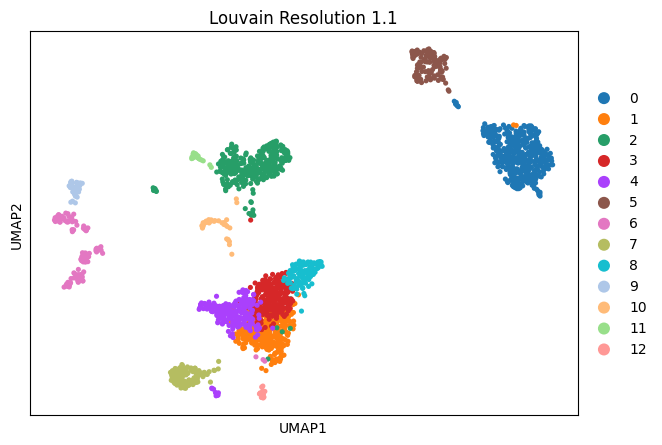

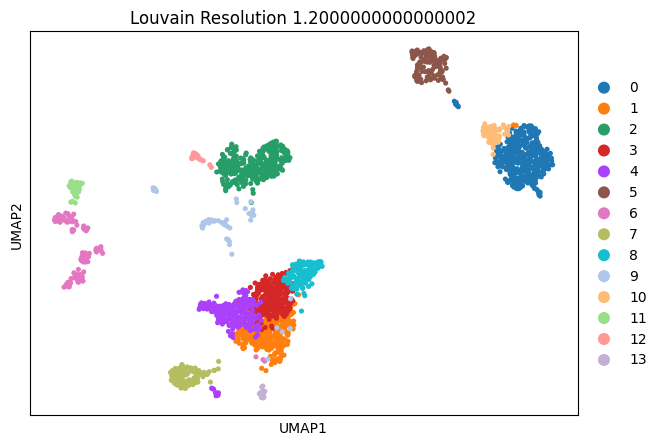

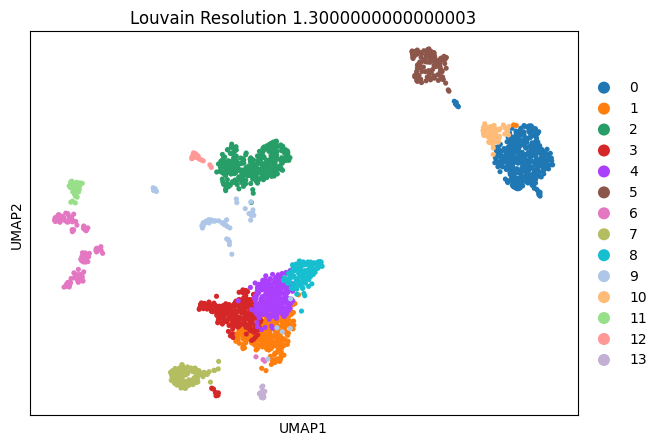

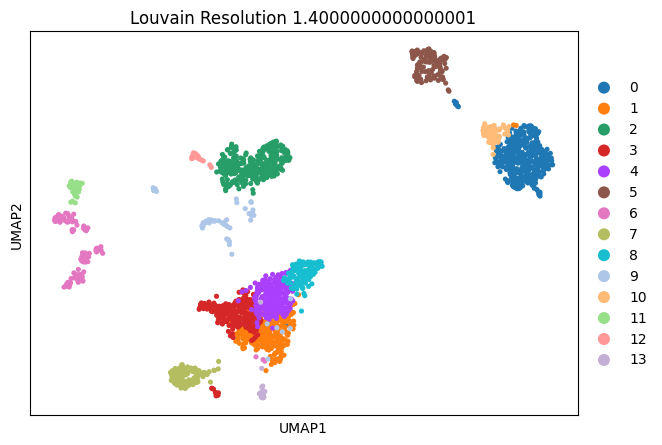

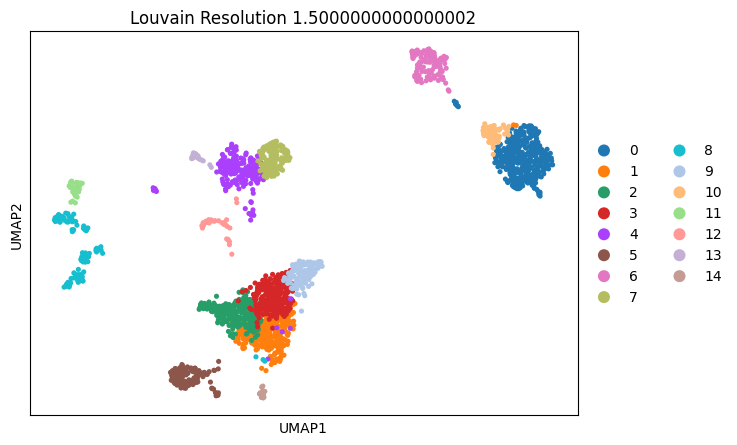

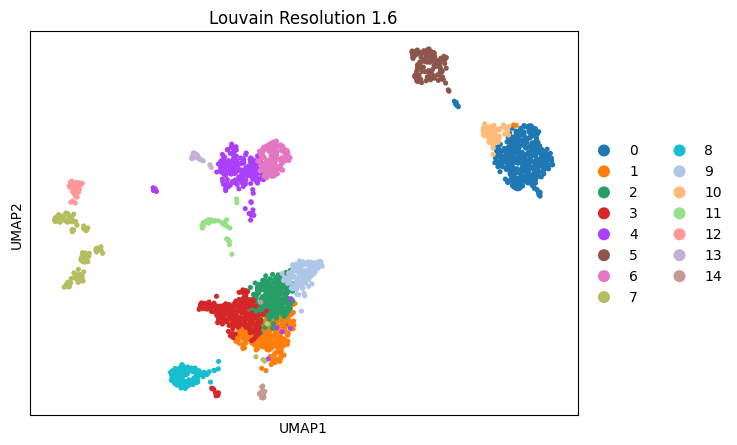

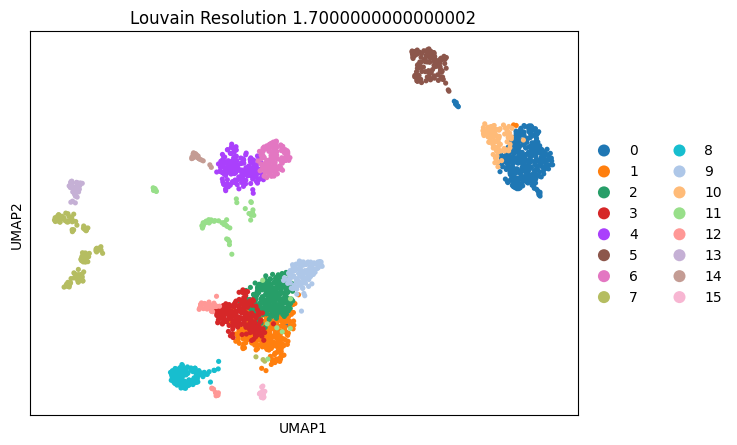

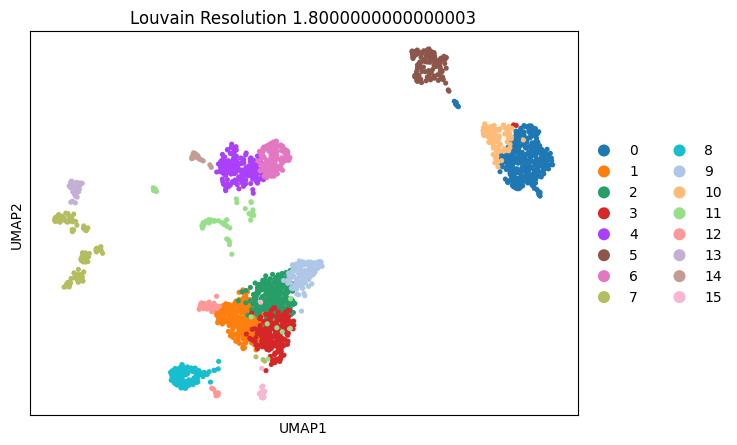

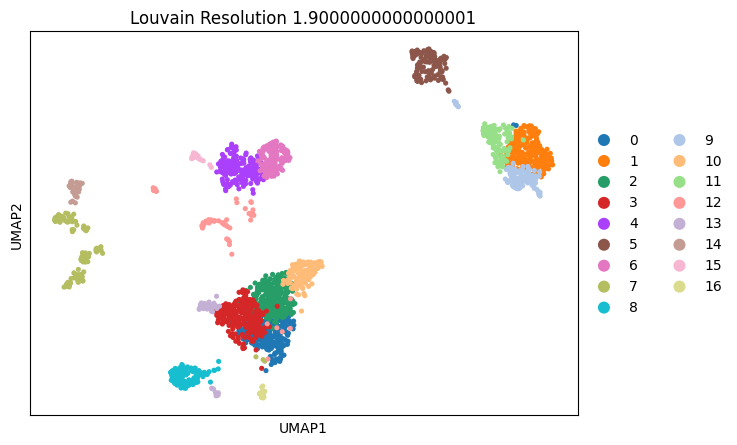

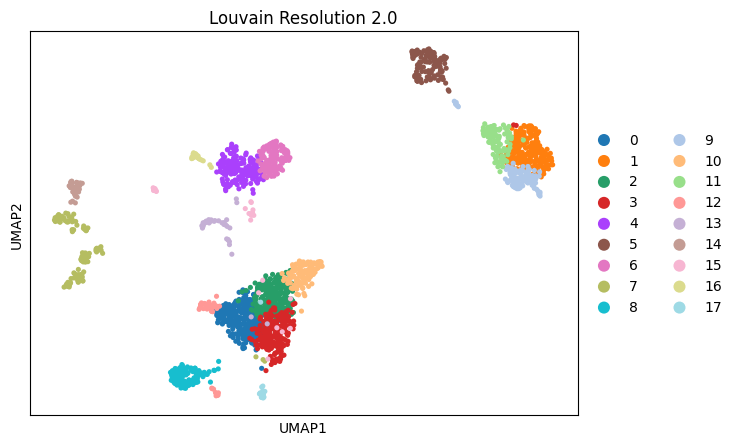

In [177]:
# Define a range of resolution values
resolutions = np.arange(0.1, 2.1, 0.1)

# Initialize dictionaries to store scores
silhouette_scores_louvain = {}
davies_bouldin_scores_louvain = {}
calinski_harabasz_scores_louvain = {}

for res in resolutions:
    # Perform Louvain clustering at the given resolution
    sc.tl.louvain(adata, resolution=res, key_added=f'louvain_{res}')

    # Retrieve the cluster labels
    labels = adata.obs[f'louvain_{res}']

    # Assuming adata.obsm['X_pca'] contains the PCA reduced data
    X_pca = adata.obsm['X_pca']

    # Calculate Silhouette Score
    silhouette_scores_louvain[res] = silhouette_score(X_pca, labels)

    # Calculate Davies-Bouldin Score
    davies_bouldin_scores_louvain[res] = davies_bouldin_score(X_pca, labels)

    # Calculate Calinski-Harabasz Score
    calinski_harabasz_scores_louvain[res] = calinski_harabasz_score(X_pca, labels)

    # Plot the clusters
    sc.pl.scatter(adata, basis='umap', color=f'louvain_{res}', title=f'Louvain Resolution {res}')

In [178]:
# Inspect the scores in the dictionaries
print("Louvain Silhouette Scores:", silhouette_scores_louvain)
print("Louvain Davies-Bouldin Scores:", davies_bouldin_scores_louvain)
print("Louvain Calinski-Harabasz Scores:", calinski_harabasz_scores_louvain)

Louvain Silhouette Scores: {0.1: 0.40667298, 0.2: 0.41627786, 0.30000000000000004: 0.40473762, 0.4: 0.18140422, 0.5: 0.18098405, 0.6: 0.18820871, 0.7000000000000001: 0.18847589, 0.8: 0.1886777, 0.9: 0.16013743, 1.0: 0.19020452, 1.1: 0.12562709, 1.2000000000000002: 0.11133254, 1.3000000000000003: 0.110799275, 1.4000000000000001: 0.110714056, 1.5000000000000002: 0.115115464, 1.6: 0.10839235, 1.7000000000000002: 0.10210062, 1.8000000000000003: 0.103309974, 1.9000000000000001: 0.087274596, 2.0: 0.08990148}
Louvain Davies-Bouldin Scores: {0.1: 1.1768604387618515, 0.2: 1.1543449229290283, 0.30000000000000004: 1.2309067473232373, 0.4: 1.3348174830115447, 0.5: 1.4564419517320073, 0.6: 1.3194720556398876, 0.7000000000000001: 1.380491717673866, 0.8: 1.3774691612900944, 0.9: 1.4386351663695673, 1.0: 1.3178022927706048, 1.1: 1.8105834211226521, 1.2000000000000002: 2.017793925762711, 1.3000000000000003: 2.0167950638719887, 1.4000000000000001: 2.016268769319897, 1.5000000000000002: 1.990466085114304

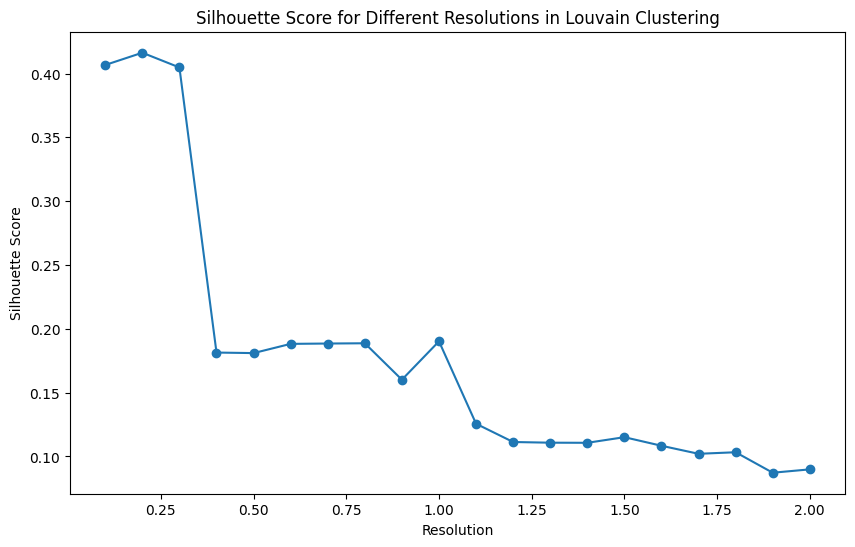

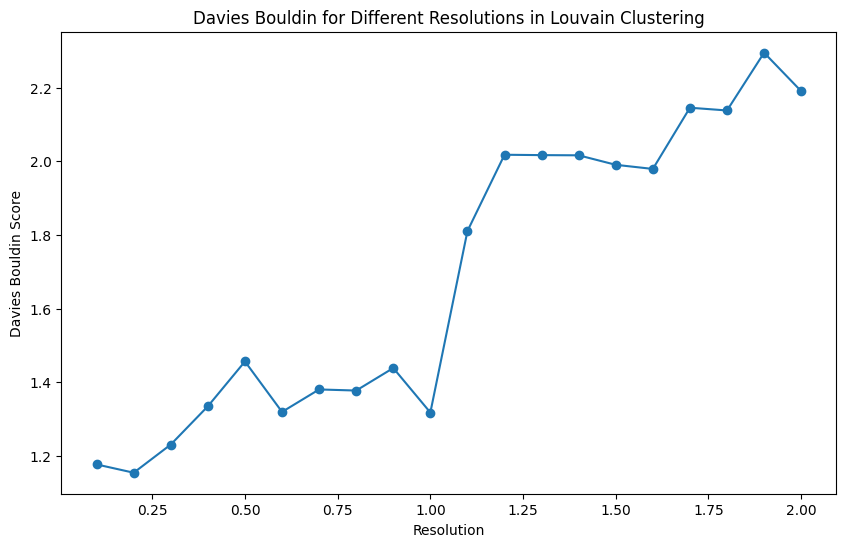

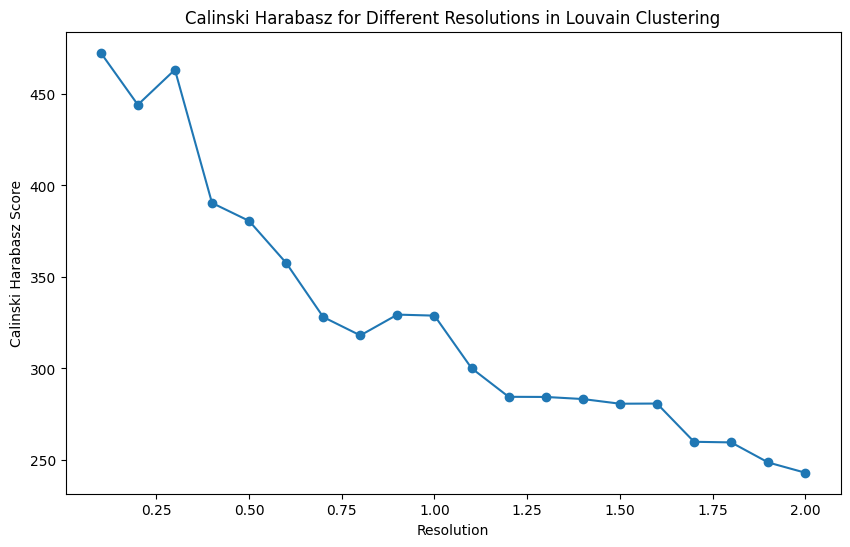

In [179]:
# Plotting Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores_louvain.keys()), list(silhouette_scores_louvain.values()), marker='o')
plt.xlabel("Resolution")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Resolutions in Louvain Clustering")
plt.show()

# Plotting Davies Bouldin Score
plt.figure(figsize=(10, 6))
plt.plot(list(davies_bouldin_scores_louvain.keys()), list(davies_bouldin_scores_louvain.values()), marker='o')
plt.xlabel("Resolution")
plt.ylabel("Davies Bouldin Score")
plt.title("Davies Bouldin for Different Resolutions in Louvain Clustering")
plt.show()

# Plotting Calinski Harabasz Score
plt.figure(figsize=(10, 6))
plt.plot(list(calinski_harabasz_scores_louvain.keys()), list(calinski_harabasz_scores_louvain.values()), marker='o')
plt.xlabel("Resolution")
plt.ylabel("Calinski Harabasz Score")
plt.title("Calinski Harabasz for Different Resolutions in Louvain Clustering")
plt.show()

To assess the best parameters for the Louvian model, the followinf scores are used:
1. Silhouette Score: Ta metric used to evaluate the quality of clusters in a dataset. A higher Silhouette Score indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters, suggesting a good clustering arrangement.
2. Davies-Bouldin Score: evaluates the average similarity between each cluster and its most similar cluster, relative to the average dissimilarity between points in different clusters. A lower Davies-Bouldin Score indicates better separation between clusters, with well-defined and compact clusters having lower scores.
3. Calinski-Harabasz Score: a metric used to evaluate the density and separation of clusters. A higher Calinski-Harabasz Score suggests better clustering performance, with distinct and well-separated clusters.

As we can see for based on these visualizations, the best model is likely the 1.1 resolution. It balances all the metric scores and has enough clusters that would explain the known cell types in brains (at least 10).

## 6.2 Leiden model

<ipython-input-180-aa324029cb15>:11: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')


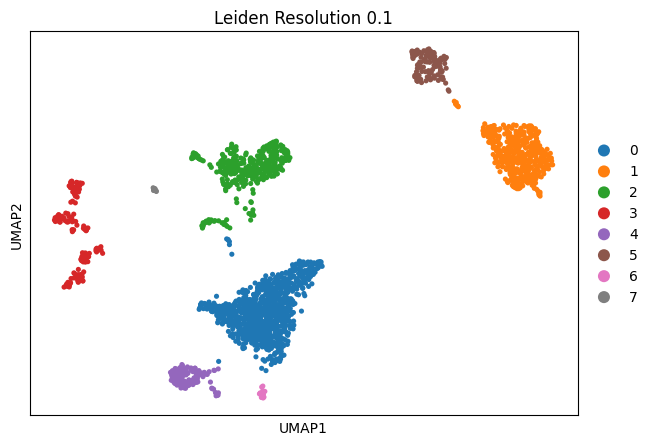

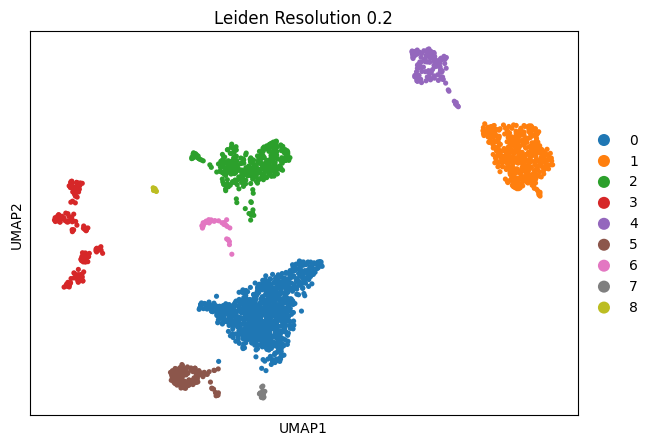

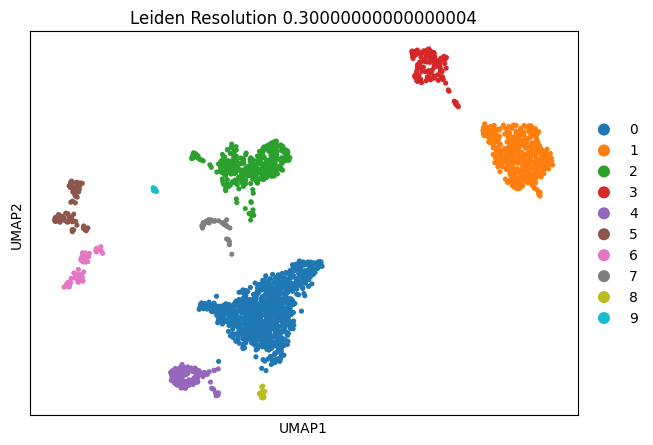

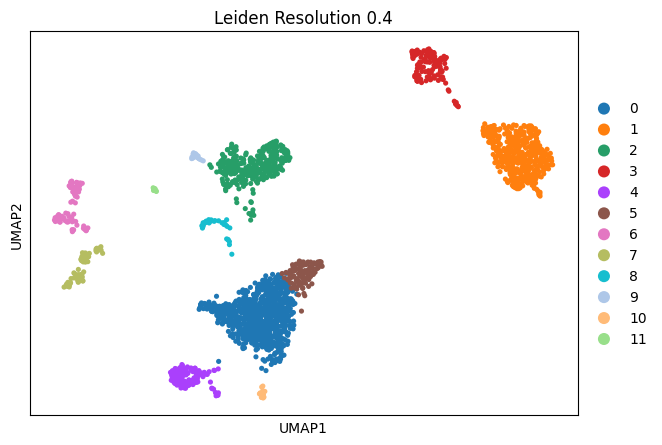

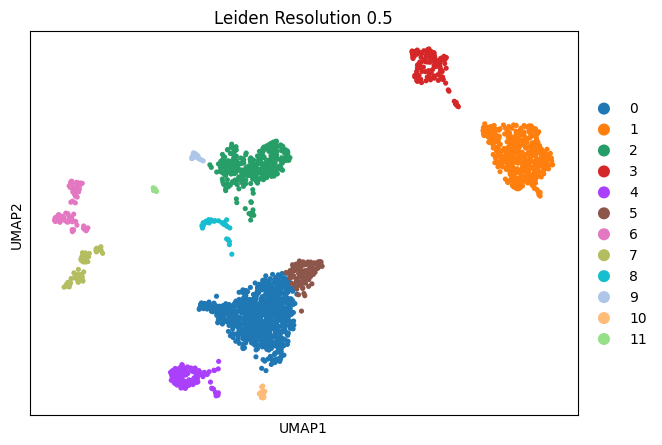

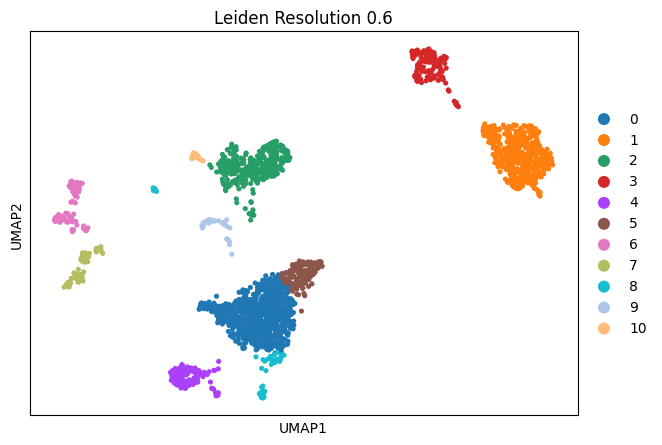

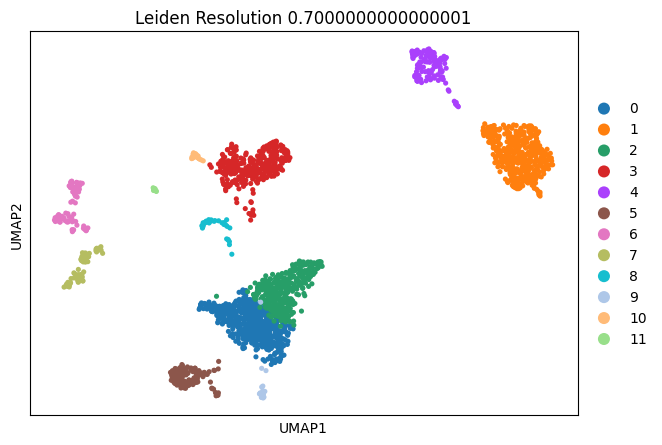

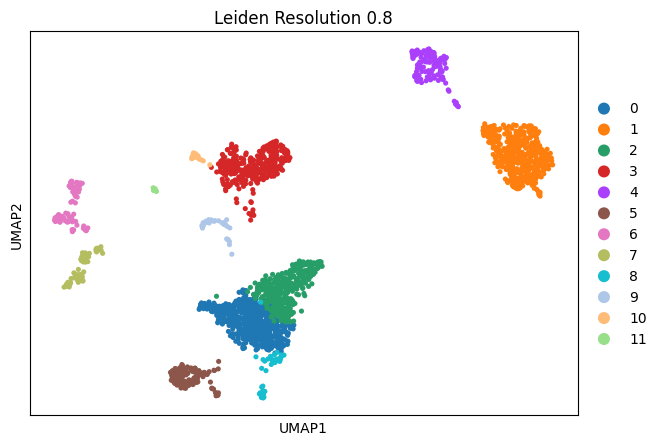

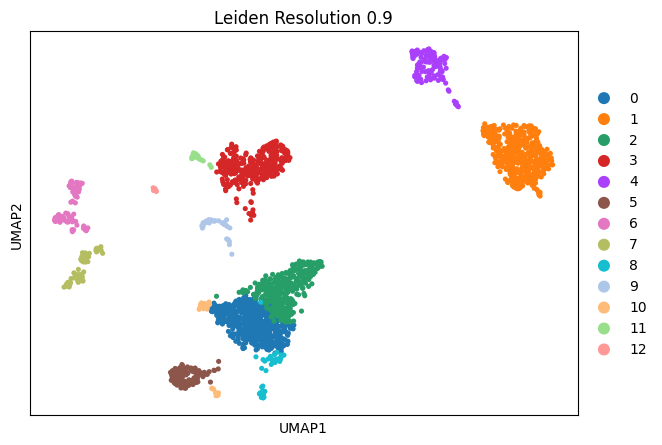

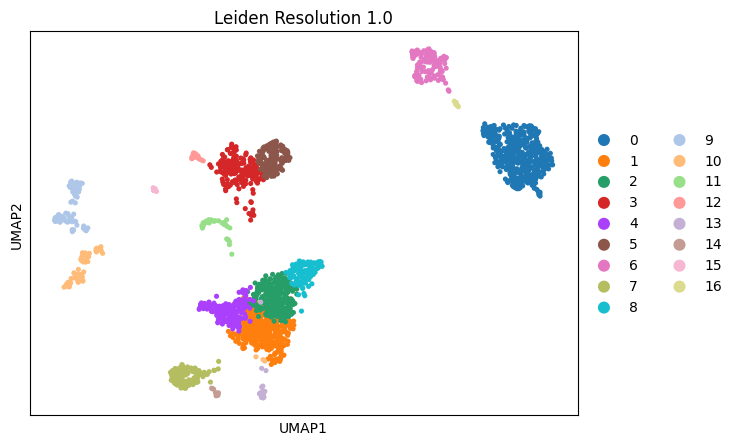

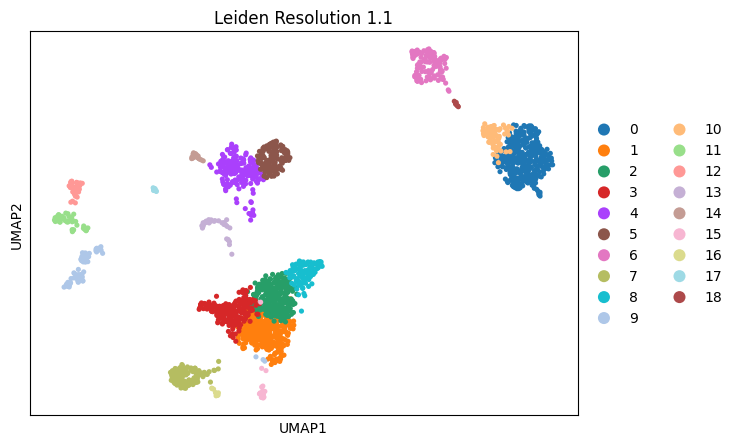

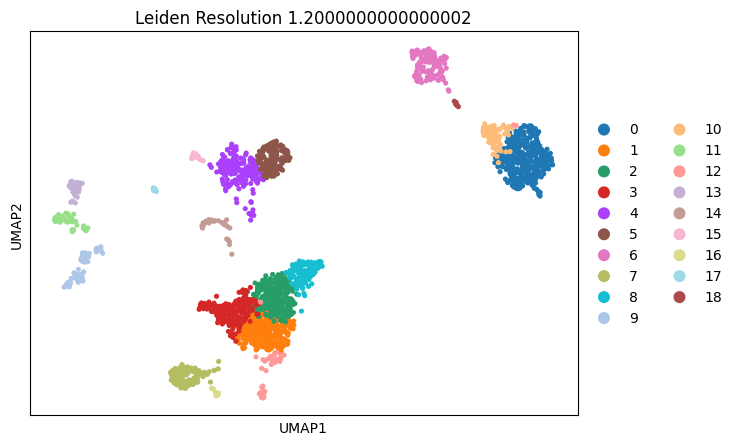

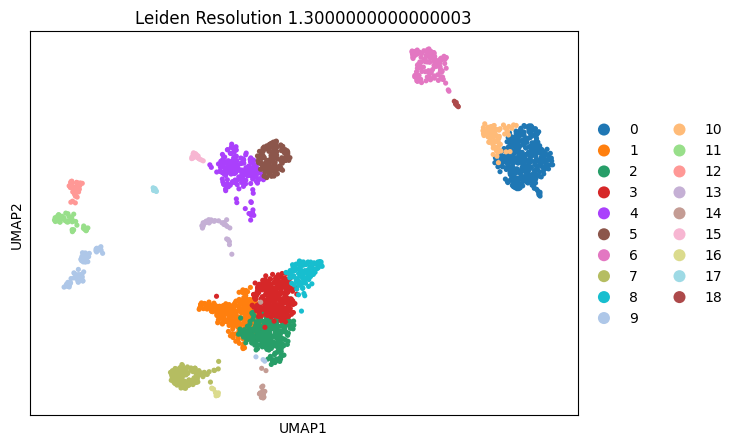

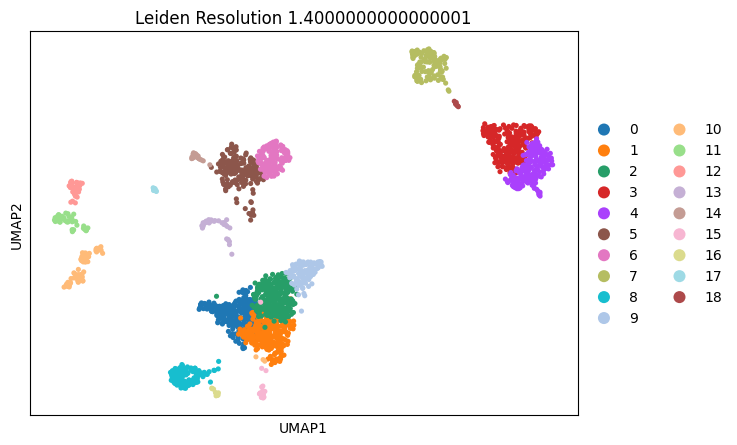

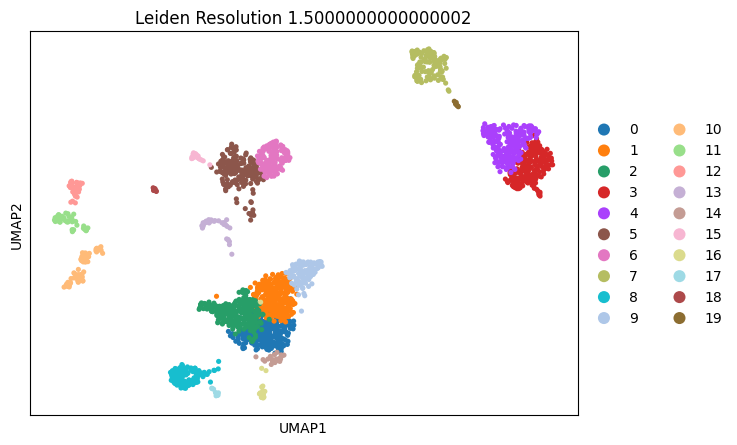

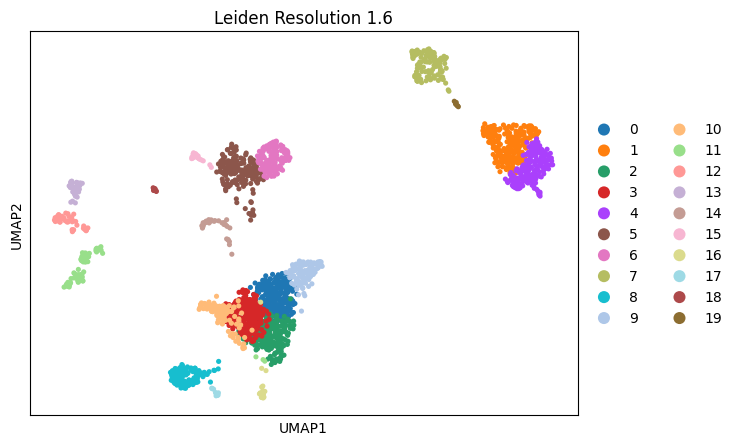

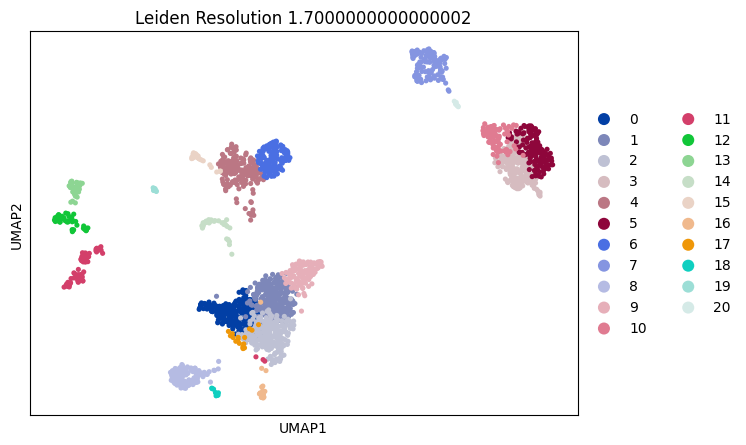

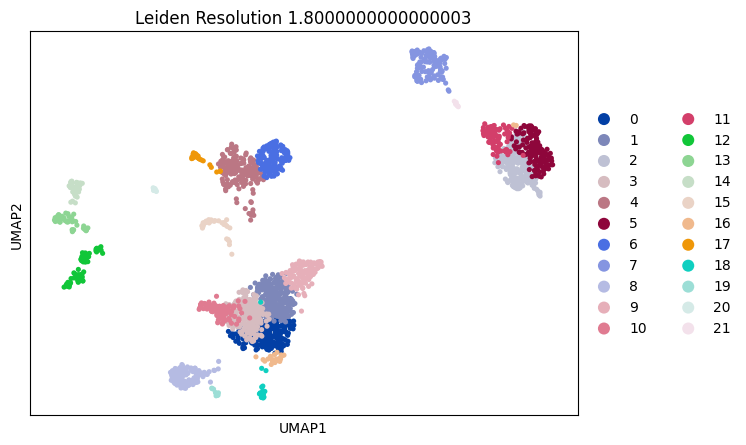

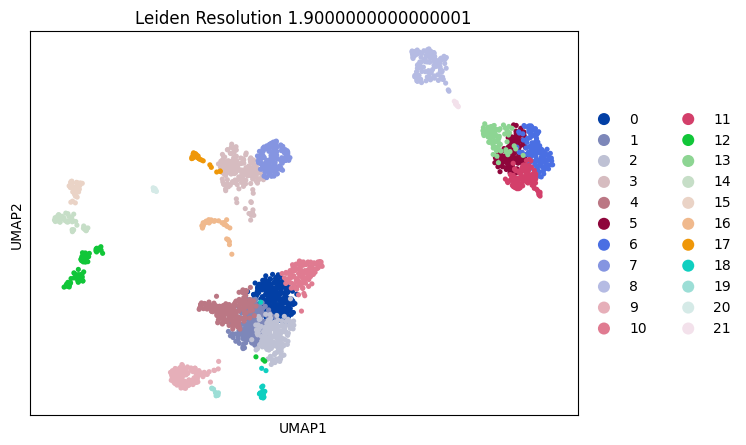

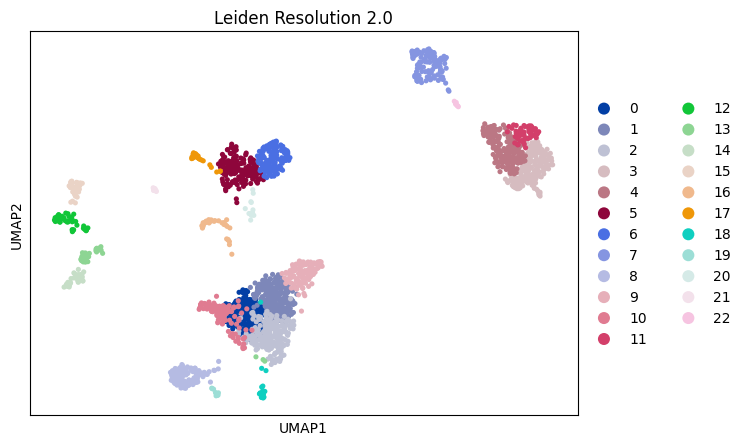

In [180]:
# Define a range of resolution values
resolutions = np.arange(0.1, 2.1, 0.1)

# Initialize dictionaries to store scores
silhouette_scores_leiden = {}
davies_bouldin_scores_leiden = {}
calinski_harabasz_scores_leiden = {}

for res in resolutions:
    # Perform Louvain clustering at the given resolution
    sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')

    # Retrieve the cluster labels
    labels = adata.obs[f'leiden_{res}']

    # Assuming adata.obsm['X_pca'] contains the PCA reduced data
    X_pca = adata.obsm['X_pca']

    # Calculate Silhouette Score
    silhouette_scores_leiden[res] = silhouette_score(X_pca, labels)

    # Calculate Davies-Bouldin Score
    davies_bouldin_scores_leiden[res] = davies_bouldin_score(X_pca, labels)

    # Calculate Calinski-Harabasz Score
    calinski_harabasz_scores_leiden[res] = calinski_harabasz_score(X_pca, labels)

    # Plot the clusters
    sc.pl.scatter(adata, basis='umap', color=f'leiden_{res}', title=f'Leiden Resolution {res}')

In [181]:
# Inspect the scores in the dictionaries
print("Silhouette Scores:", silhouette_scores_leiden)
print("Davies-Bouldin Scores:", davies_bouldin_scores_leiden)
print("Calinski-Harabasz Scores:", calinski_harabasz_scores_leiden)

Silhouette Scores: {0.1: 0.40391326, 0.2: 0.41038206, 0.30000000000000004: 0.41730377, 0.4: 0.19478653, 0.5: 0.1978852, 0.6: 0.18283689, 0.7000000000000001: 0.15750156, 0.8: 0.15202746, 0.9: 0.1516791, 1.0: 0.12827411, 1.1: 0.12541743, 1.2000000000000002: 0.118432745, 1.3000000000000003: 0.12399866, 1.4000000000000001: 0.10237118, 1.5000000000000002: 0.10311483, 1.6: 0.096762694, 1.7000000000000002: 0.09983914, 1.8000000000000003: 0.0969442, 1.9000000000000001: 0.0938349, 2.0: 0.086375065}
Davies-Bouldin Scores: {0.1: 1.1832662433963963, 0.2: 1.1797264076157163, 0.30000000000000004: 1.1892569122797227, 0.4: 1.2768450997826464, 0.5: 1.2700836337736148, 0.6: 1.580745580107974, 0.7000000000000001: 1.4489336726408102, 0.8: 1.553057865598175, 0.9: 1.5508382503244396, 1.0: 1.7881352521573133, 1.1: 1.8531150529200122, 1.2000000000000002: 1.9214702911994506, 1.3000000000000003: 1.8678432569735428, 1.4000000000000001: 2.003626027126482, 1.5000000000000002: 2.0470350633871646, 1.6: 2.12646244401

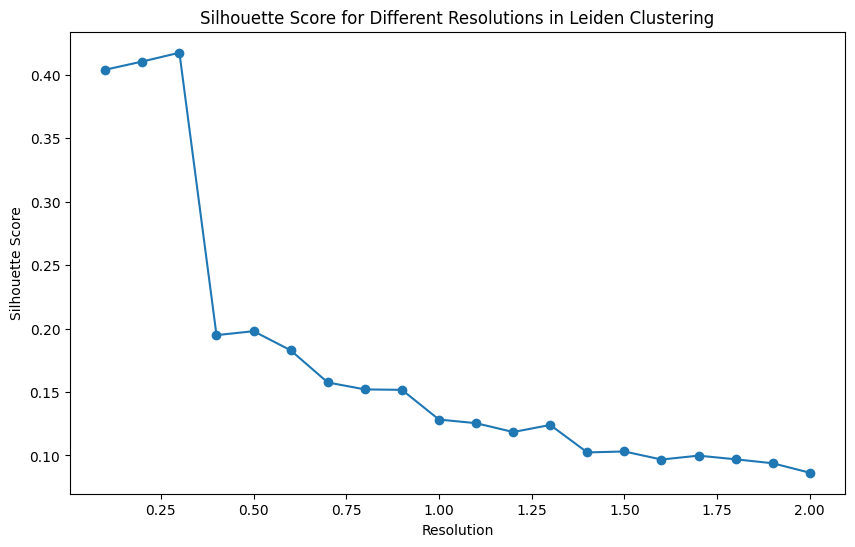

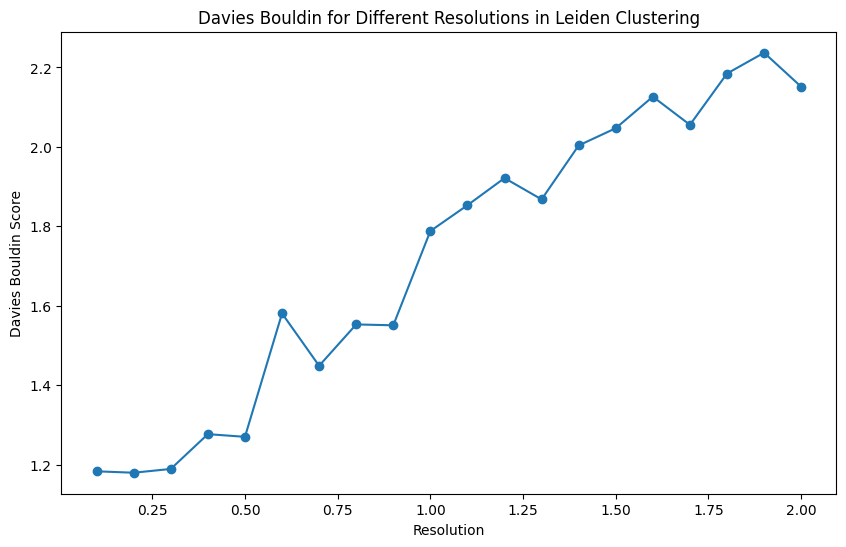

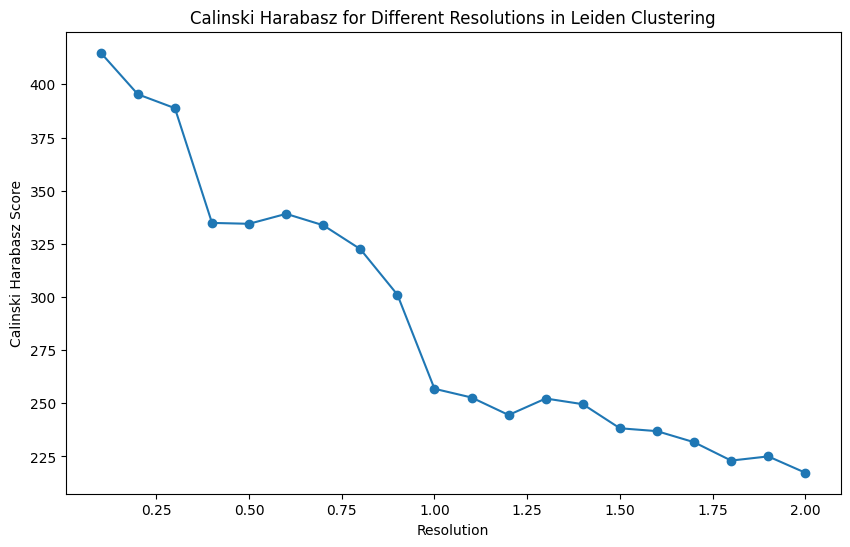

In [182]:
# Plotting Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores_leiden.keys()), list(silhouette_scores_leiden.values()), marker='o')
plt.xlabel("Resolution")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Resolutions in Leiden Clustering")
plt.show()

# Plotting Davies Bouldin Score
plt.figure(figsize=(10, 6))
plt.plot(list(davies_bouldin_scores_leiden.keys()), list(davies_bouldin_scores_leiden.values()), marker='o')
plt.xlabel("Resolution")
plt.ylabel("Davies Bouldin Score")
plt.title("Davies Bouldin for Different Resolutions in Leiden Clustering")
plt.show()

# Plotting Calinski Harabasz Score
plt.figure(figsize=(10, 6))
plt.plot(list(calinski_harabasz_scores_leiden.keys()), list(calinski_harabasz_scores_leiden.values()), marker='o')
plt.xlabel("Resolution")
plt.ylabel("Calinski Harabasz Score")
plt.title("Calinski Harabasz for Different Resolutions in Leiden Clustering")
plt.show()

As we can see for based on these visualizations, the best model is likely the 0.6 resolution. It balances all the metric scores and has enough clusters that would explain the known cell types in brains (at least 10).

## 6.3 Comparing models

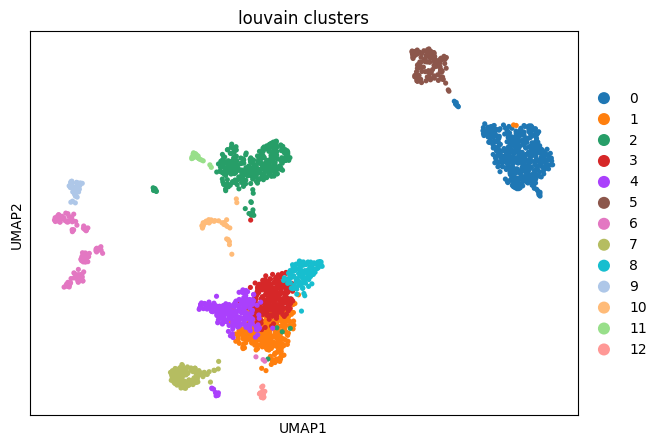

Silhouette score:  0.12562709
Davies Bouldin score:  1.8105834211226521
Calinski Harabasz score:  300.1535523744751


In [183]:
sc.tl.louvain(adata, key_added= 'louvain_clusters', resolution=1.1)
sc.pl.scatter(adata, basis='umap', color=['louvain_clusters'])

labels = adata.obs['louvain_clusters']
X_pca = adata.obsm['X_pca']

# Calculate Silhouette Score
silhouette_score_value_louvain = silhouette_score(X_pca, labels)
print("Silhouette score: ", silhouette_score_value_louvain)

# Calculate Davies-Bouldin Score
davies_bouldin_score_value_louvain = davies_bouldin_score(X_pca, labels)
print("Davies Bouldin score: ",  davies_bouldin_score_value_louvain)

# Calculate Calinski-Harabasz Score
calinski_harabasz_score_value_louvain = calinski_harabasz_score(X_pca, labels)
print("Calinski Harabasz score: ", calinski_harabasz_score_value_louvain)

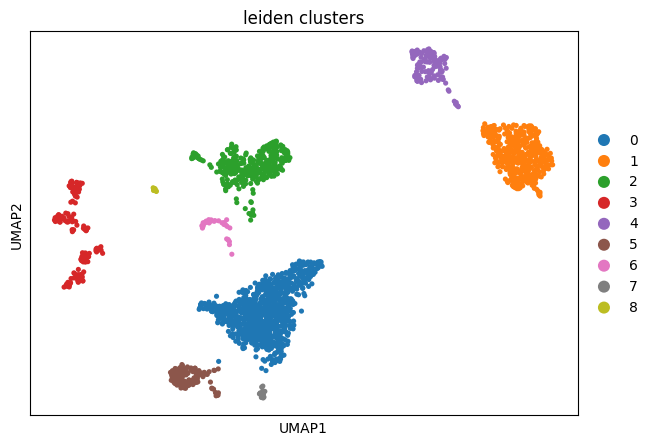

Silhouette score:  0.41038206
Davies Bouldin score:  1.1797264076157163
Calinski Harabasz score:  395.3249283663853


In [184]:
sc.tl.leiden(adata, key_added= 'leiden_clusters', resolution=0.2)
sc.pl.scatter(adata, basis='umap', color=['leiden_clusters'])

labels = adata.obs['leiden_clusters']
X_pca = adata.obsm['X_pca']

# Calculate Silhouette Score
silhouette_score_value_leiden = silhouette_score(X_pca, labels)
print("Silhouette score: ", silhouette_score_value_leiden)

# Calculate Davies-Bouldin Score
davies_bouldin_score_value_leiden = davies_bouldin_score(X_pca, labels)
print("Davies Bouldin score: ",  davies_bouldin_score_value_leiden)

# Calculate Calinski-Harabasz Score
calinski_harabasz_score_value_leiden = calinski_harabasz_score(X_pca, labels)
print("Calinski Harabasz score: ", calinski_harabasz_score_value_leiden)

For the combined original dataset, the Leiden model has a better performance with a higher Silhoutte score, lower Davies Bouldin score, and a higher Calinski-Harabasz score.

## 6.4 Testing with subsets

Now, we will see if the Leiden model performs well with the subsets.

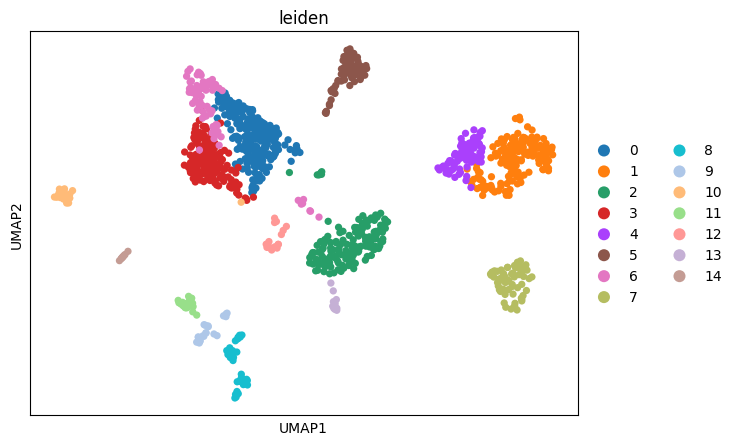

First Subset's Silhouette score:  0.12400238
First Subset's Davies Bouldin score:  1.5859870827977678
First Subset's Calinski Harabasz score:  153.18535268747974


In [191]:
# First subset:

sc.tl.leiden(first_subset_adata, resolution=0.4)
sc.pl.scatter(first_subset_adata, basis='umap', color=['leiden'])

labels_first_subset = first_subset_adata.obs['leiden']
X_pca_first_subset = first_subset_adata.obsm['X_pca']

# Calculate Silhouette Score
first_subset_silhouette_score = silhouette_score(X_pca_first_subset, labels_first_subset)
print("First Subset's Silhouette score: ", first_subset_silhouette_score)

# Calculate Davies-Bouldin Score
first_subset_davies_bouldin_score = davies_bouldin_score(X_pca_first_subset, labels_first_subset)
print("First Subset's Davies Bouldin score: ",  first_subset_davies_bouldin_score)

# Calculate Calinski-Harabasz Score
first_subset_calinski_harabasz_score = calinski_harabasz_score(X_pca_first_subset, labels_first_subset)
print("First Subset's Calinski Harabasz score: ", first_subset_calinski_harabasz_score)

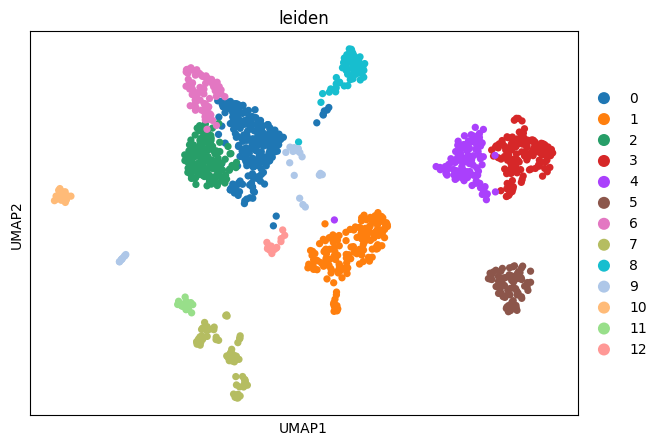

Second Subset's Silhouette score:  0.12644102
Second Subset's Davies Bouldin score:  1.6674578990636897
Second Subset's Calinski Harabasz score:  171.32226755437688


In [193]:
# Second subset:

sc.tl.leiden(second_subset_adata, resolution=0.4)
sc.pl.scatter(second_subset_adata, basis='umap', color=['leiden'])

labels_second_subset = second_subset_adata.obs['leiden']
X_pca_second_subset = second_subset_adata.obsm['X_pca']

# Calculate Silhouette Score
second_subset_silhouette_score = silhouette_score(X_pca_second_subset, labels_second_subset)
print("Second Subset's Silhouette score: ", second_subset_silhouette_score)

# Calculate Davies-Bouldin Score
second_subset_davies_bouldin_score = davies_bouldin_score(X_pca_second_subset, labels_second_subset)
print("Second Subset's Davies Bouldin score: ",  second_subset_davies_bouldin_score)

# Calculate Calinski-Harabasz Score
second_subset_calinski_harabasz_score = calinski_harabasz_score(X_pca_second_subset, labels_second_subset)
print("Second Subset's Calinski Harabasz score: ", second_subset_calinski_harabasz_score)

The scores on the subsets show that the Leiden model is not very consistent with the same type of data. This is likely due to the low sample size in a brain dataset. However, on all types of data, the metrics are acceptable for the current standards in research. A likely future improvement of this model would use more robust datasets that do not split the data into subsets that are too small.

# 7. Analyzing Gene Markers.

## 7.1 Gene markers in cluster

For this section, I tried to form cell clusters based on the gene expressions. Doing so requires an understanding of genes that are highly expressed in certain cells but less in other cells.

Based on recent literature, these are:
1. Astrocyte: Aldh1l1, Slc1a3, Aqp4,
2. Oligodendrocyte: Mog, Mag,
3. Oligodendrocyte Precursor Cell: Pdgfra, Susd5,Cspg4,
4. Endothelial Cell: Pecam1, Cldn5, Slco1c1, Ocln,
5. Bergmann Glial Cell': Gdf10, Vim, Nbl1, A2m,
6. Excitatory Neuron': Slc17a7, Neurod6, Mab21l1,
7. Inhibitory Neuron': Gad1, Reln,Calb1,
8. Brain Pericyte': Des, Mcam,Pdgfrb.

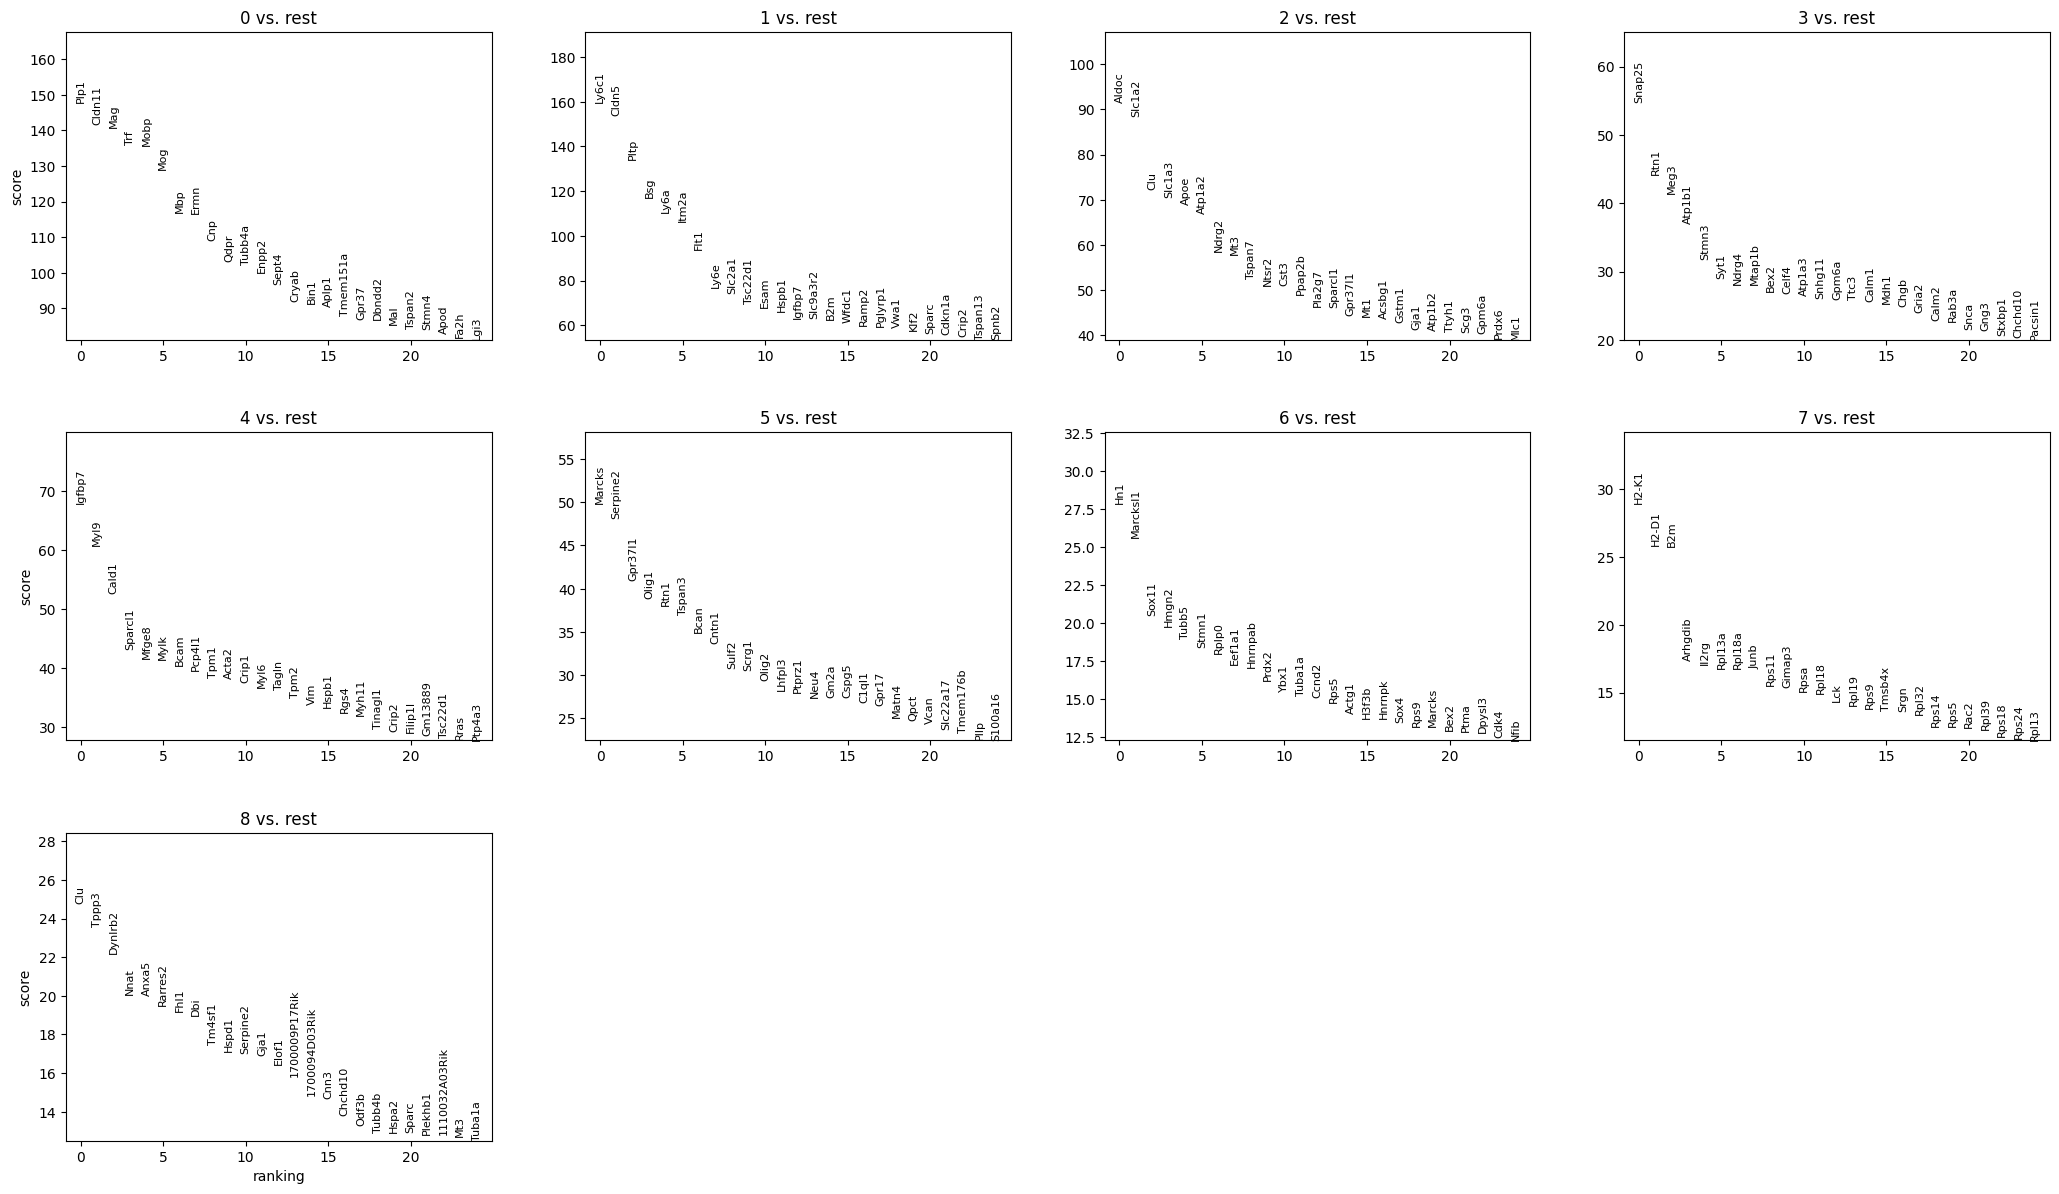

In [196]:
# Identifying significantly enriched genes in each cluster
sc.tl.rank_genes_groups(adata, 'leiden_clusters', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

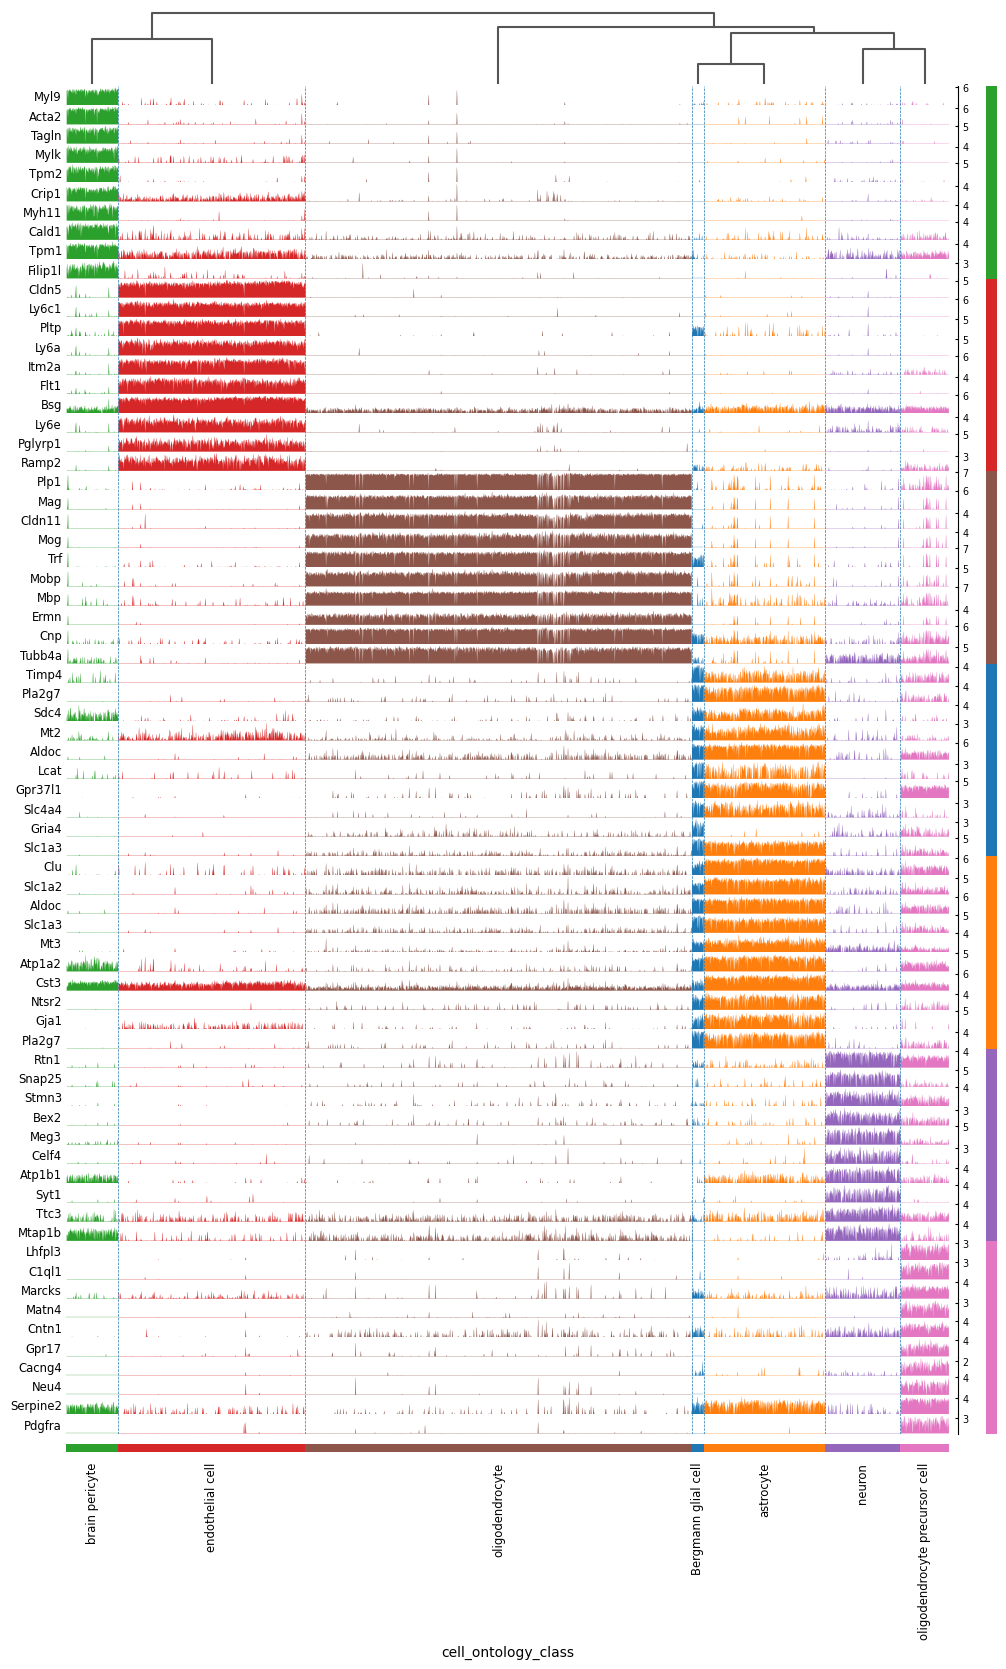

In [197]:
sc.tl.rank_genes_groups(adata, groupby='cell_ontology_class', use_raw=True,
                        method='t-test_overestim_var', n_genes=10)
sc.pl.rank_genes_groups_tracksplot(adata, groupby='cell_ontology_class')

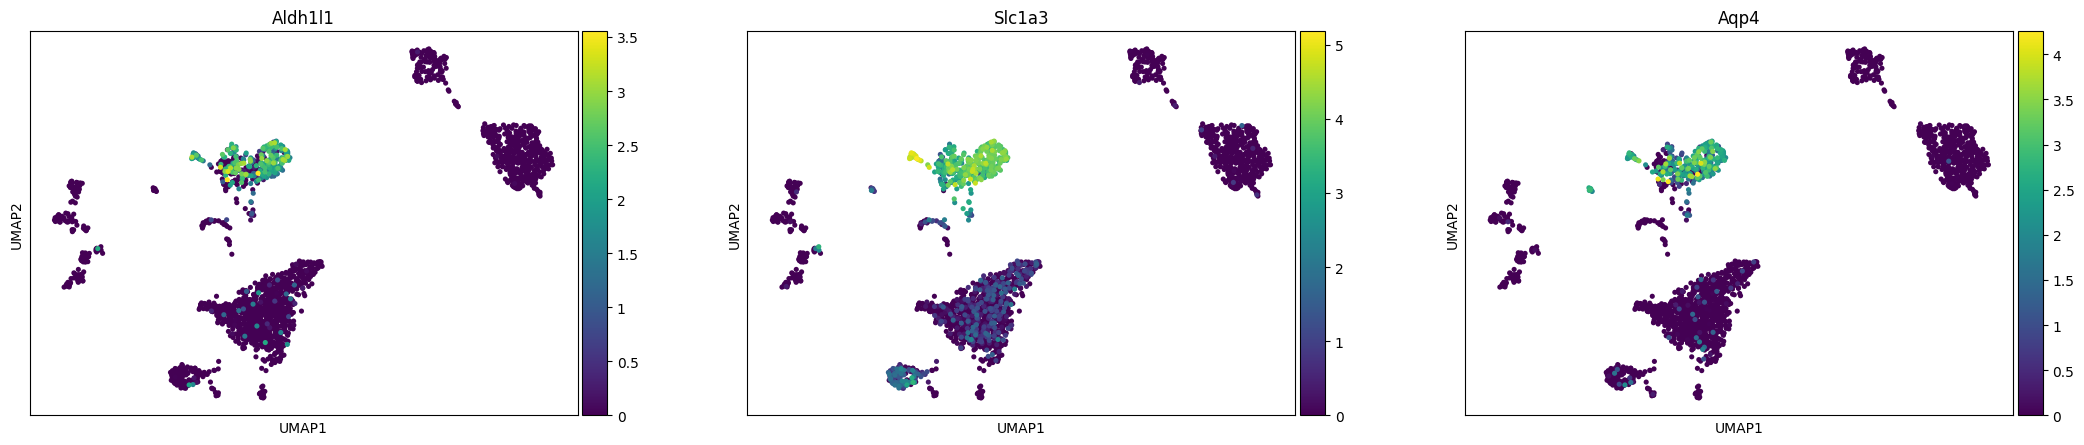

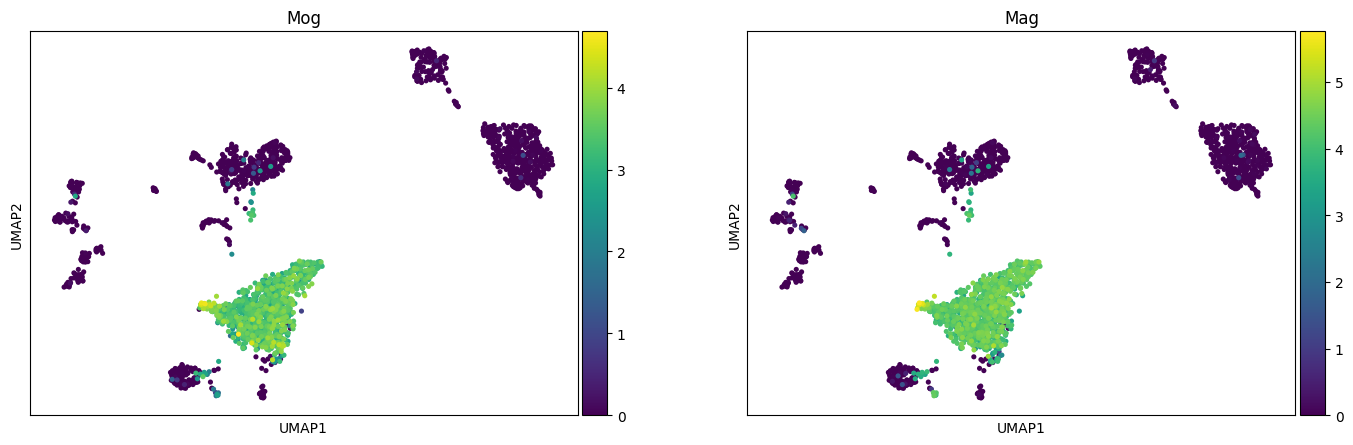

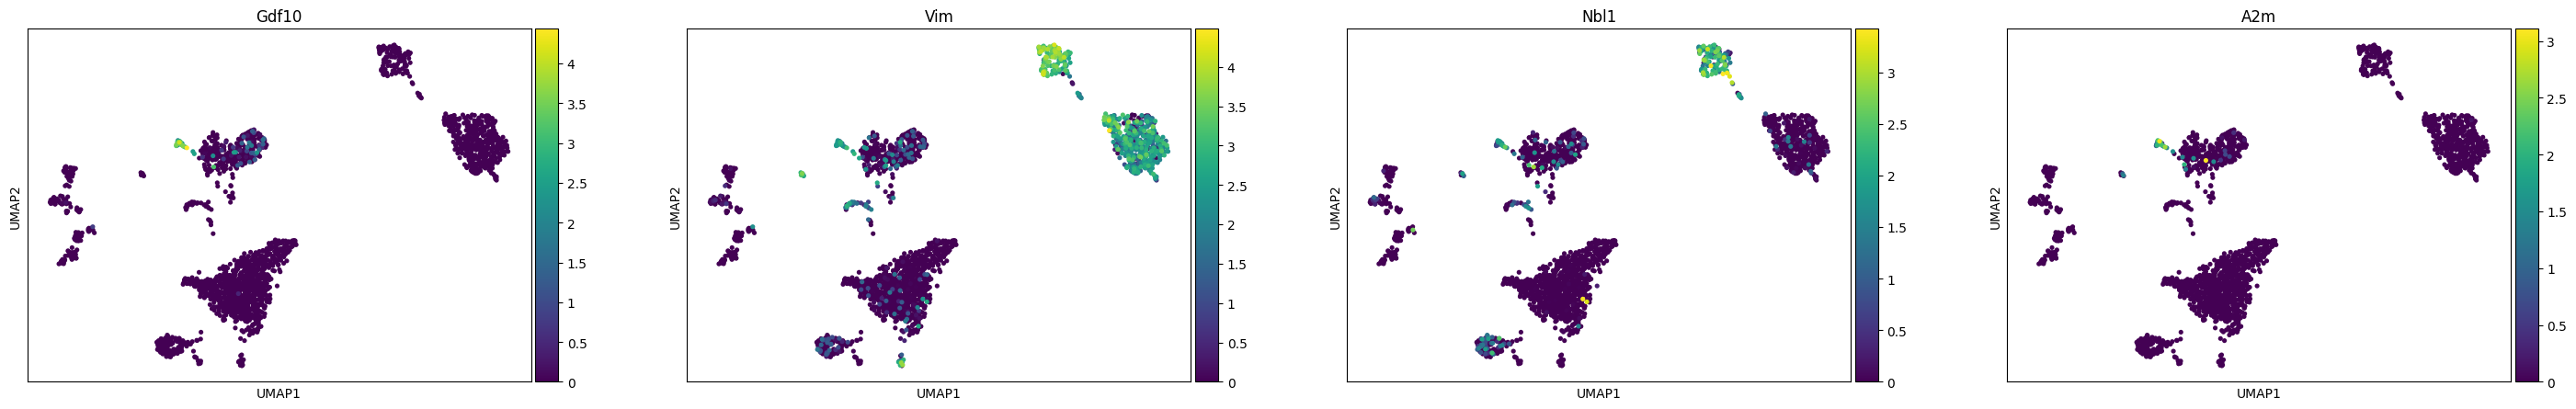

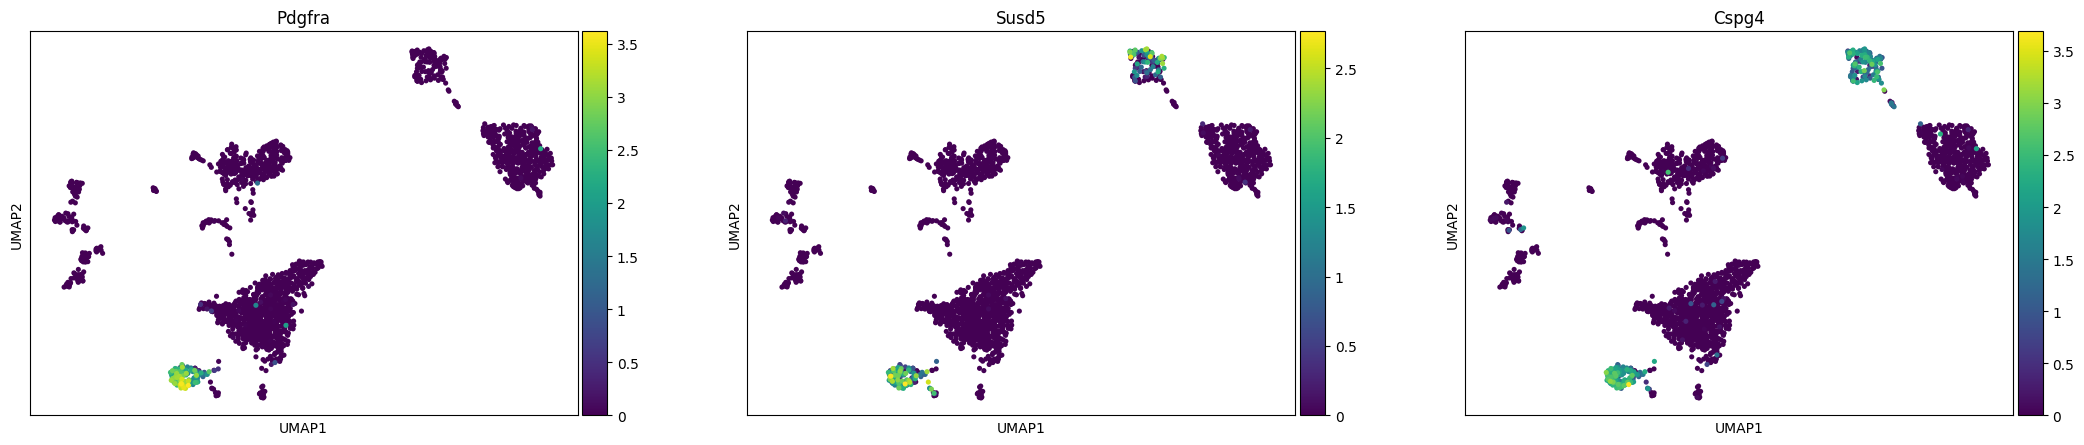

In [198]:
# Visualizing the expression of specific marker genes known for pancreatic islets cell types
sc.pl.scatter(adata, basis='umap', color=['Aldh1l1', 'Slc1a3','Aqp4'])
sc.pl.scatter(adata, basis='umap', color=['Mog', 'Mag'])
sc.pl.scatter(adata, basis='umap', color=['Gdf10','Vim','Nbl1','A2m'])
sc.pl.scatter(adata, basis='umap', color=['Pdgfra', 'Susd5', 'Cspg4'])

As you can see, the cell clusters are pretty well-formed for specific known gene expressions.

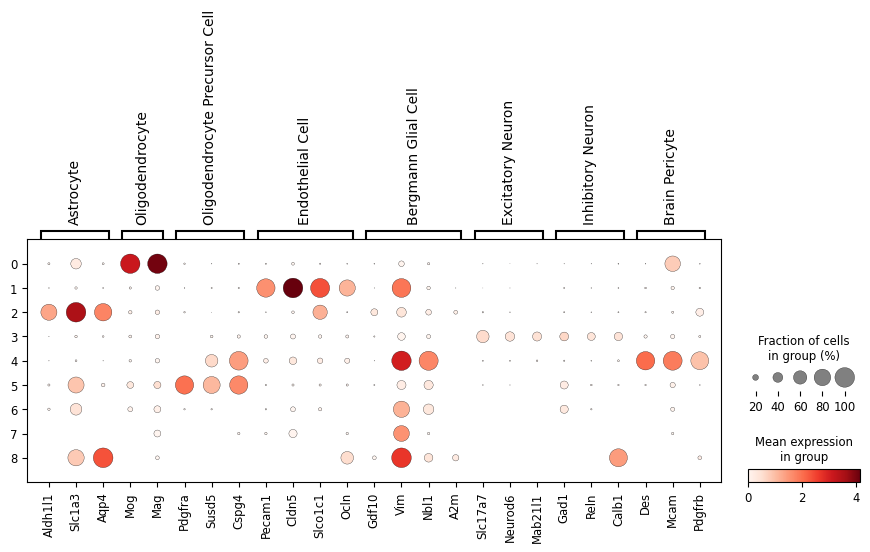

In [200]:
marker_genes = {
'Astrocyte': ['Aldh1l1', 'Slc1a3', 'Aqp4'],
'Oligodendrocyte': ['Mog','Mag'],
'Oligodendrocyte Precursor Cell': ['Pdgfra','Susd5','Cspg4'],
'Endothelial Cell': ['Pecam1','Cldn5','Slco1c1','Ocln'],
'Bergmann Glial Cell': ['Gdf10','Vim','Nbl1','A2m'],
'Excitatory Neuron': ['Slc17a7','Neurod6','Mab21l1'],
'Inhibitory Neuron': ['Gad1','Reln','Calb1'],
'Brain Pericyte': ['Des','Mcam','Pdgfrb']
}
# Dotplot for visualization that combines gene expression data for these specific markers of cell types
# with clustering information
sc.pl.dotplot(adata, marker_genes, 'leiden_clusters')

In [203]:
# Using the previous information to annotate cell types

map_names = {}

for c in adata.obs['louvain_clusters'].cat.categories:
    if c in ['1']:
        map_names[c] = 'Endothelial Cell'
    elif c in ['0']:
        map_names[c] = 'Oligodendrocyte'
    elif c in ['2']:
        map_names[c] = 'Astrocyte'
    elif c in ['3']:
        map_names[c] = 'Excitatory Neuron'
    elif c in ['4','6','7','8']:
        map_names[c] = 'Bergmann Glial Cell'
    elif c in ['5']:
        map_names[c] = 'Oligodendrocyte Precursor Cell'
    else:
        map_names[c] = c

adata.obs['clusters_annotations'] = adata.obs['leiden_clusters']
adata.obs['clusters_annotations'] = adata.obs['clusters_annotations'].map(map_names).astype('category')
adata.obs['Cell_Type'] = adata.obs['clusters_annotations'].cat.reorder_categories(
    ['Astrocyte', 'Oligodendrocyte', 'Oligodendrocyte Precursor Cell','Endothelial Cell',
     'Bergmann Glial Cell', 'Excitatory Neuron'])

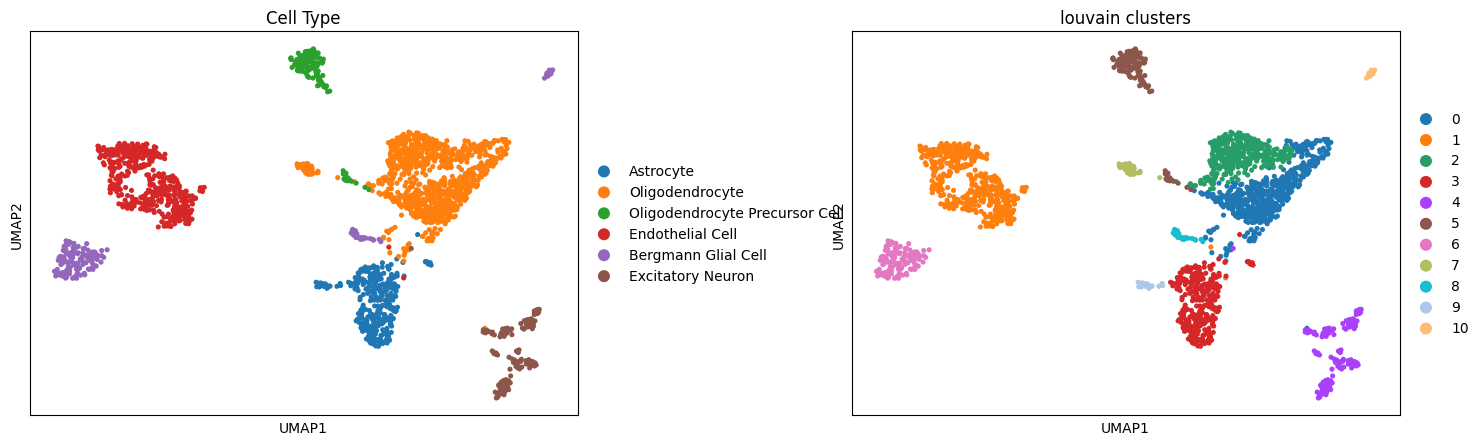

In [ ]:
# Visualizing cell types and clusters on the UMAP
sc.pl.scatter(adata, basis='umap', color=['Cell_Type', 'louvain_clusters'])

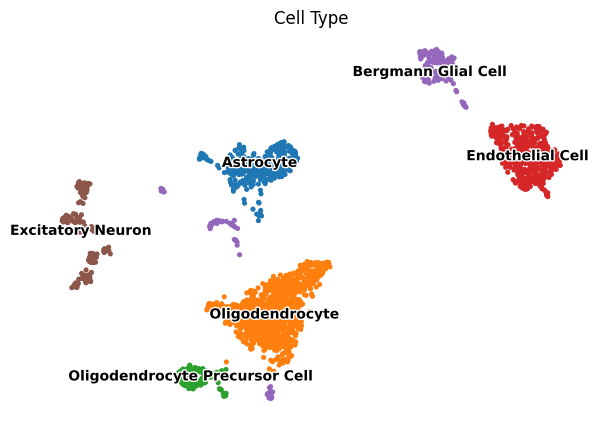

In [204]:
sc.pl.scatter(adata, basis='umap', color='Cell_Type', legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

# 8. Conclusion

Overall, the final clusters show a good ability to discern between cell types based on genetic expression. However, the sample's data size is a big limitation as I was not able to find expressions for inhibitory neurons and the testing with stratified sampling yielded very inconsistent results.

There is a lot to be optmistic about - the clear clustering of cells shows a lot of promise for future applications given enough computational resources and access to private datasets with higher volumes of samples.

## References

Elsadec, M. Y. (2024, April 18). *A Comparative Analysis of Clustering scRNA-seq Data Using PCA-Based and GNN-Driven Approaches.* Medium. https://medium.com/@mohamed.y.elsadec_56085/a-comparative-analysis-of-clustering-scrna-seq-data-using-pca-based-and-gnn-driven-approaches-24c9fb8d5ec8

Hrvatin, S., Hochbaum, D. R., Nagy, M. A., Cicconet, M., Robertson, K., Cheadle, L., & Greenberg, M. E. (2018). Single-cell analysis of experience-dependent transcriptomic states in the mouse visual cortex. *Nature neuroscience, 21(1)*, 120-129.https://www.nature.com/articles/s41586-018-0590-4

Iram, T., & Tabula Muris Consortium. (2018). Single-cell transcriptomics of 20 mouse organs creates a Tabula Muris. *Nature, 562(7727)*, 367-372. https://weizmann.elsevierpure.com/en/publications/single-cell-transcriptomics-of-20-mouse-organs-creates-a-tabula-m

Mathys, H., Davila-Velderrain, J., Peng, Z., Gao, F., Mohammadi, S., Young, J. Z., ... & Tsai, L. H. (2019). Single-cell transcriptomic analysis of Alzheimer’s disease. *Nature, 570(7761)*, 332-337. https://www.nature.com/articles/s41586-019-1195-2

Ofengeim, D., Giagtzoglou, N., Huh, D., Zou, C., & Yuan, J. (2017). Single-cell RNA sequencing: unraveling the brain one cell at a time. *Trends in molecular medicine, 23(6)*, 563-576. https://www.cell.com/trends/molecular-medicine/abstract/S1471-4914(17)30075-8

Zeng, H., & Sanes, J. R. (2017). Neuronal cell-type classification: challenges, opportunities and the path forward. *Nature Reviews Neuroscience, 18(9)*, 530-546. https://www.med.upenn.edu/ngg/assets/user-content/documents/jc-2020-2021/cell-type-classification-zengsanes-nrn.-review-01.11.pdf

